In [2]:
import os
import sys
import random
import time
from random import seed, randint
import argparse
import platform
from datetime import datetime
import imp
import numpy as np
import fileinput
from itertools import product
import pandas as pd
from scipy.interpolate import griddata
from scipy.interpolate import interp2d
import seaborn as sns
from os import listdir

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import griddata
import matplotlib as mpl
# sys.path.insert(0,'..')
# from notebookFunctions import *
# from .. import notebookFunctions
from Bio.PDB.Polypeptide import one_to_three
from Bio.PDB.Polypeptide import three_to_one
from Bio.PDB.PDBParser import PDBParser
from pyCodeLib import *
from small_script.myFunctions import *
from collections import defaultdict
%matplotlib inline
# plt.rcParams['figure.figsize'] = (10,6.180)    #golden ratio
# %matplotlib notebook
%load_ext autoreload
%autoreload 2

In [3]:
plt.rcParams['figure.figsize'] = [16.18033, 10]    #golden ratio
plt.rcParams['figure.facecolor'] = 'w'
plt.rcParams['figure.dpi'] = 100

In [5]:
pdb_list = ["2bg9", "1j4n", "1py6_SD", "2bl2", "1rhz", "1iwg", "2ic8", "1pv6", "1occ", "1kpl", "2bs2", "1py6", "1u19"]


In [10]:
simulationType = "openMM_membrane_structure_prediction"
# folder = "original"
folder = "with_pulling"
all_data = []
for pdb in pdb_list:
    for i in range(20):
        for restart in range(2):
            location = f"/Users/weilu/Research/server/jun_2019/{simulationType}/{folder}/{pdb}/{i}_{restart}/info.dat"
            try:
                tmp = pd.read_csv(location, sep="\s+")
                tmp = tmp.assign(Run=i, Protein=pdb, Restart=restart)
                all_data.append(tmp)
            except:
                print(pdb, i, restart)
                pass
data = pd.concat(all_data)
today = datetime.today().strftime('%m-%d')
data.reset_index(drop=True).to_csv(f"/Users/weilu/Research/data/openMM/{simulationType}_{folder}_{today}.csv")


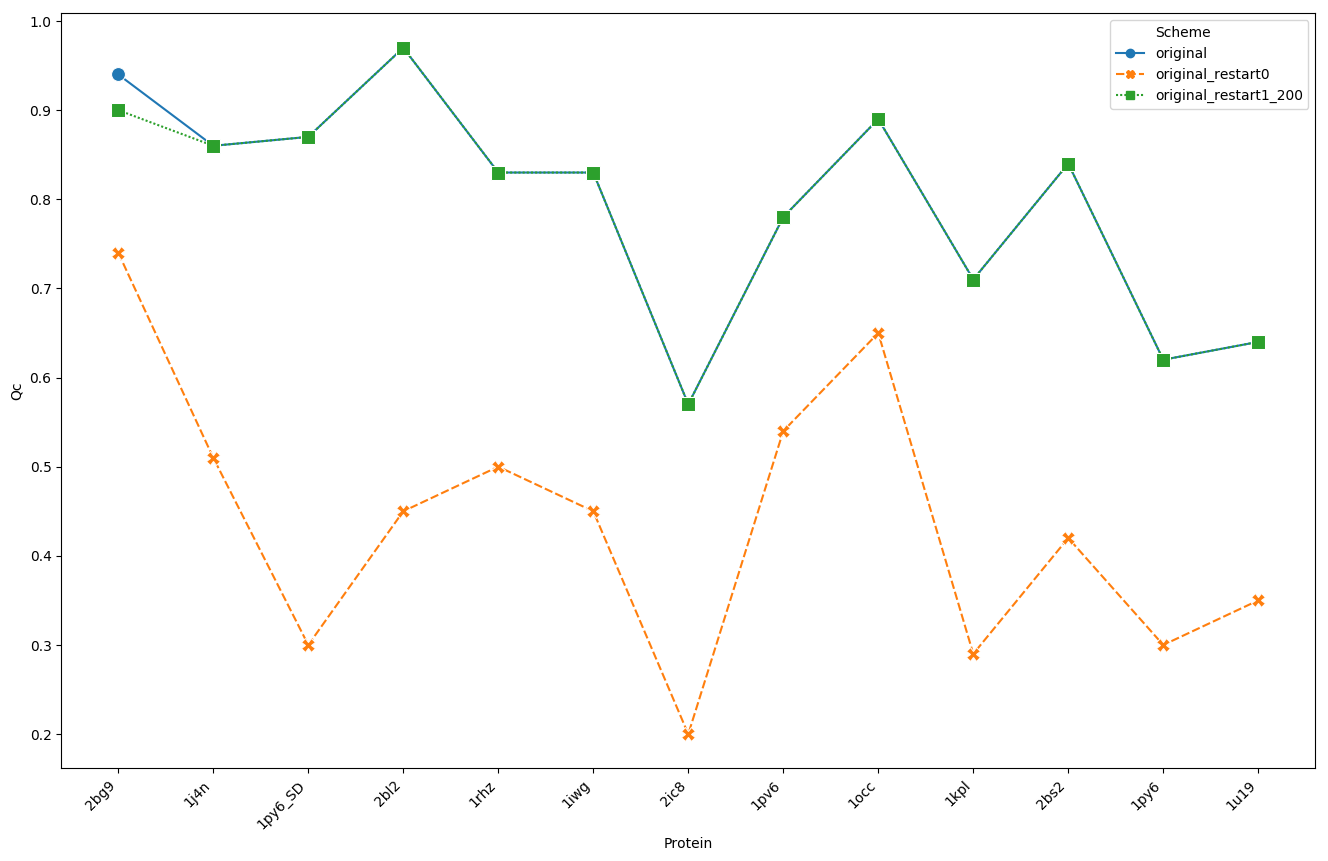

In [16]:
ax = sns.lineplot(x="Protein", y="Qc", hue="Scheme", style="Scheme", markers=True, ms=10, data=max_data)
_ = ax.set_xticklabels(labels=pdb_list, rotation=45, ha='right')

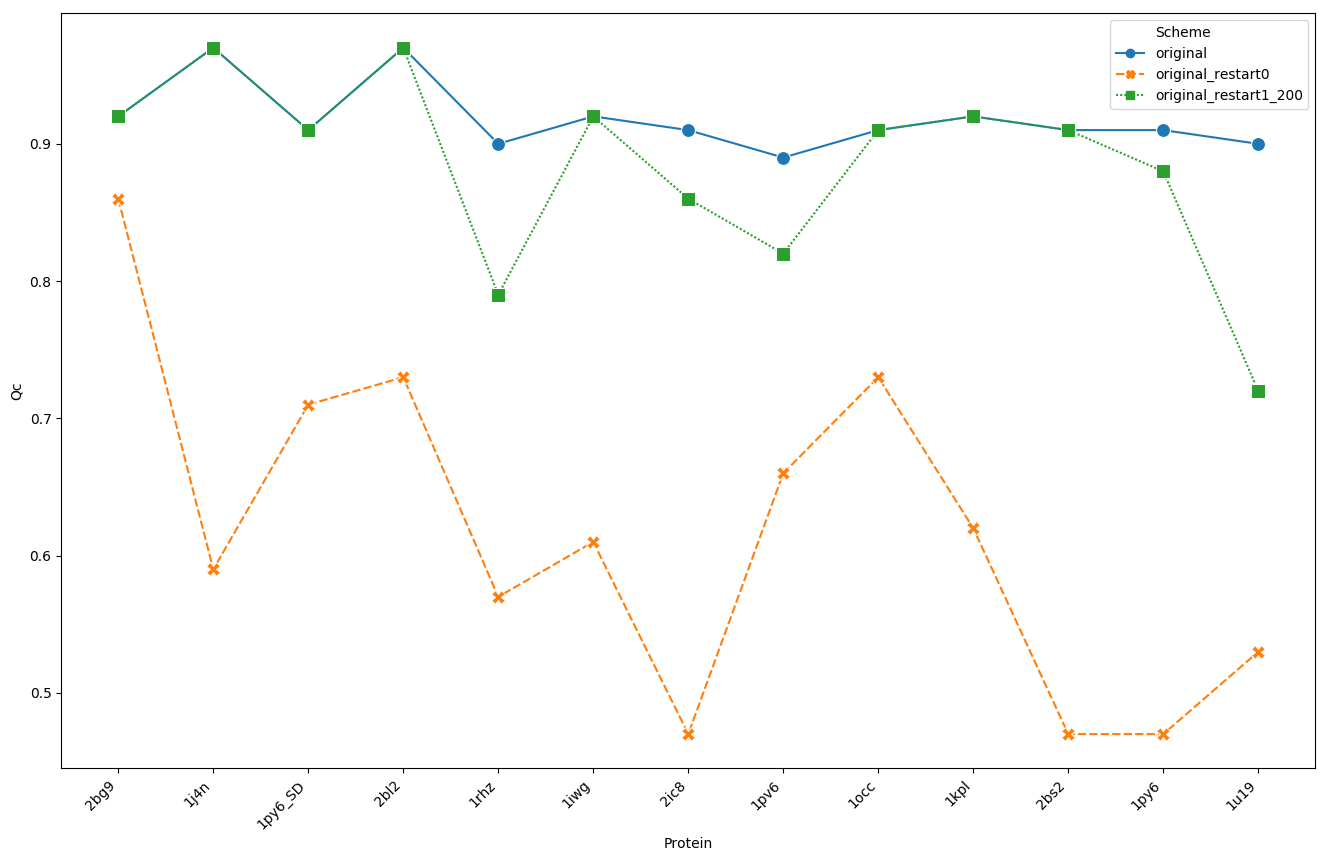

In [56]:
ax = sns.lineplot(x="Protein", y="Qc", hue="Scheme", style="Scheme", markers=True, ms=10, data=max_data)
_ = ax.set_xticklabels(labels=pdb_list, rotation=45, ha='right')

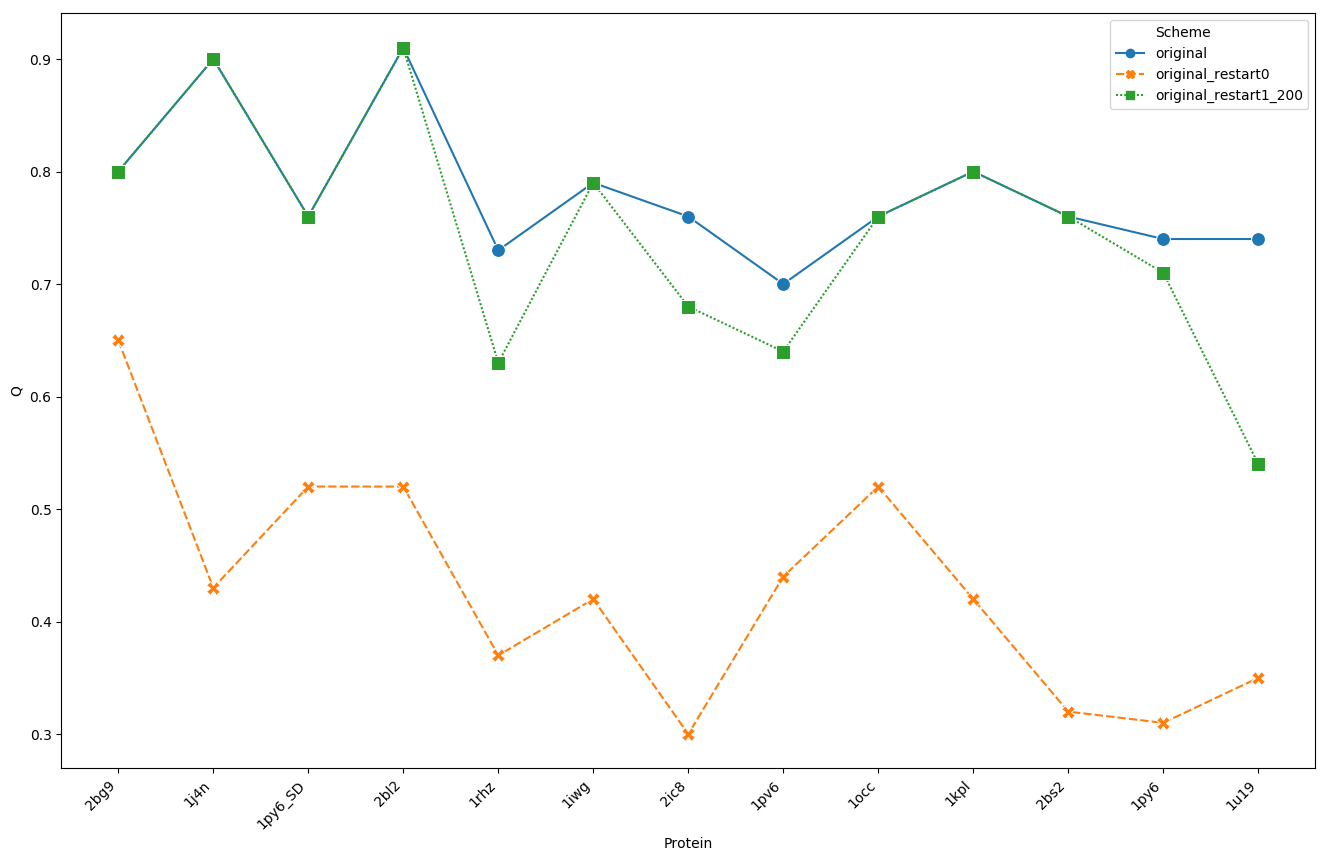

In [59]:
max_Q_data = d.groupby(["Protein", "Scheme"])["Q"].max().reset_index()
ax = sns.lineplot(x="Protein", y="Q", hue="Scheme", style="Scheme", markers=True, ms=10, data=max_Q_data)
_ = ax.set_xticklabels(labels=pdb_list, rotation=45, ha='right')

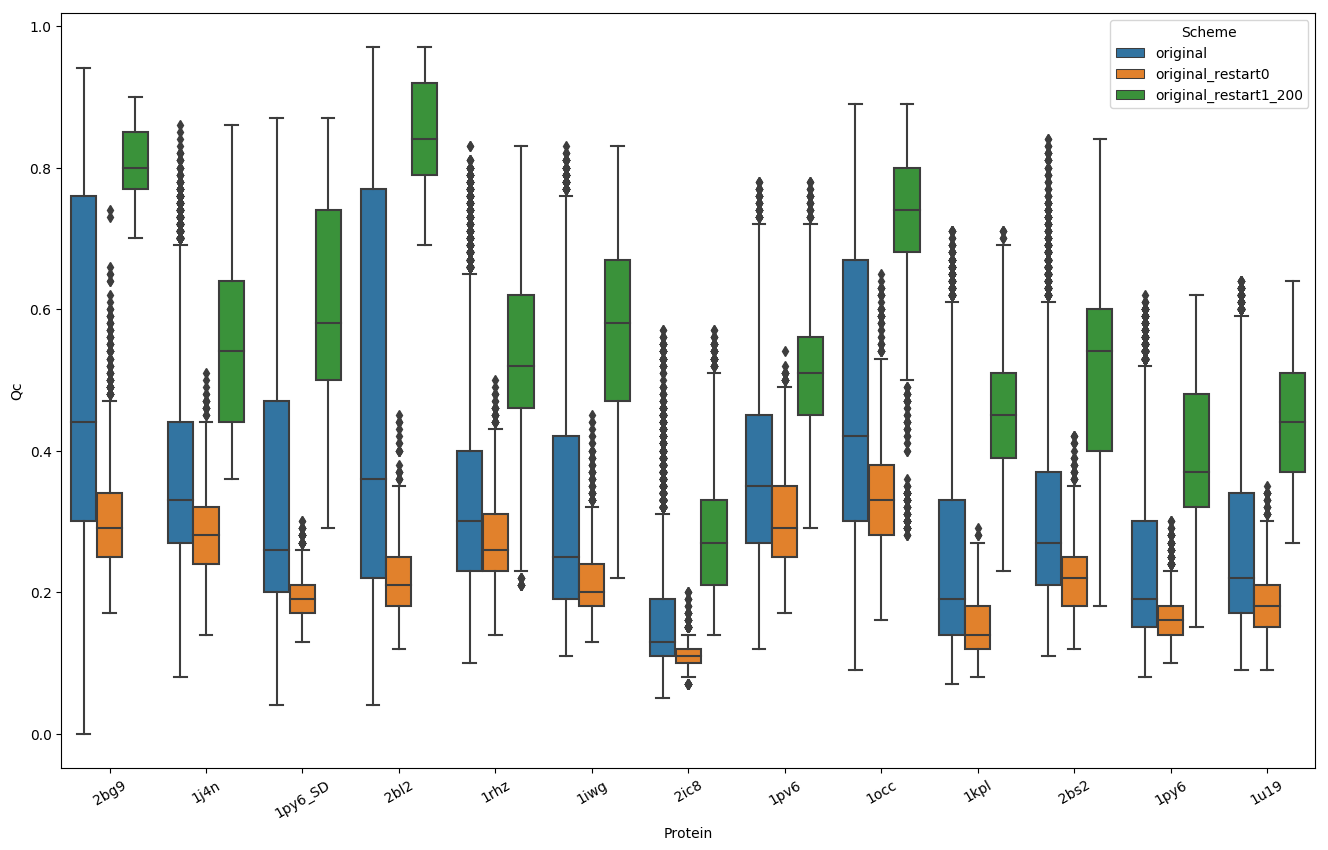

In [15]:
data1 = pd.read_csv("/Users/weilu/Research/data/openMM/openMM_membrane_structure_prediction_with_pulling_06-18.csv", index_col=0)

# data2 = pd.read_csv("/Users/weilu/Research/data/openMM/openMM_multiLetter_frags_original_06-04.csv", index_col=0)
# data3 = pd.read_csv("/Users/weilu/Research/data/openMM/openMM_multiLetter_jun02_original_06-03.csv", index_col=0)

d = pd.concat([
#     data3.assign(Scheme="original"), 
    data1.assign(Scheme="original"), 
#     data1.query("Restart == 0").assign(Scheme="original_restart0_all"), 
    data1.query("Steps > 100 and Steps < 200 and Restart == 0").assign(Scheme="original_restart0"), 
#                 data1.query("Restart == 1").assign(Scheme="original_restart1"), 
    data1.query("Steps > 300 and Restart == 1").assign(Scheme="original_restart1_200"), 
#                 data2.query("Steps > 80 and Restart == 1").assign(Scheme="original"),

              ])
d.Protein = pd.Categorical(d.Protein, 
                      categories=pdb_list,
                      ordered=True)
max_data = d.groupby(["Protein", "Scheme"])["Qc"].max().reset_index()
# plt.plot
sns.boxplot("Protein", "Qc", hue="Scheme", data=d)
# sns.boxplot("Qw", "Name", hue="Scheme", data=d)
_ = plt.xticks(rotation=30)

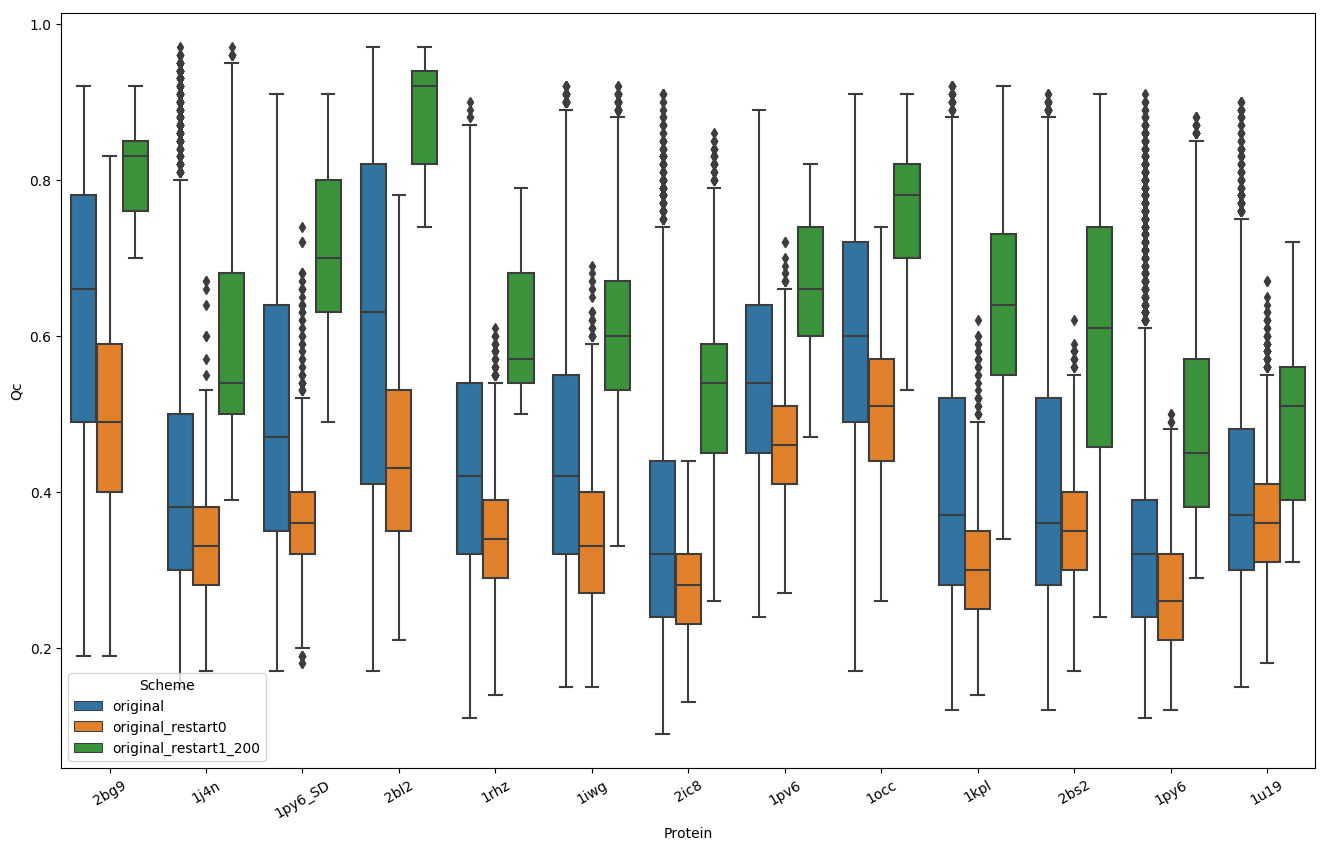

In [13]:
data1 = pd.read_csv("/Users/weilu/Research/data/openMM/openMM_membrane_structure_prediction_original_06-14.csv", index_col=0)

# data2 = pd.read_csv("/Users/weilu/Research/data/openMM/openMM_multiLetter_frags_original_06-04.csv", index_col=0)
# data3 = pd.read_csv("/Users/weilu/Research/data/openMM/openMM_multiLetter_jun02_original_06-03.csv", index_col=0)

d = pd.concat([
#     data3.assign(Scheme="original"), 
    data1.assign(Scheme="original"), 
#     data1.query("Restart == 0").assign(Scheme="original_restart0_all"), 
    data1.query("Steps > 100 and Steps < 200 and Restart == 0").assign(Scheme="original_restart0"), 
#                 data1.query("Restart == 1").assign(Scheme="original_restart1"), 
    data1.query("Steps > 300 and Restart == 1").assign(Scheme="original_restart1_200"), 
#                 data2.query("Steps > 80 and Restart == 1").assign(Scheme="original"),

              ])
d.Protein = pd.Categorical(d.Protein, 
                      categories=pdb_list,
                      ordered=True)
max_data = d.groupby(["Protein", "Scheme"])["Qc"].max().reset_index()
# plt.plot
sns.boxplot("Protein", "Qc", hue="Scheme", data=d)
# sns.boxplot("Qw", "Name", hue="Scheme", data=d)
_ = plt.xticks(rotation=30)

In [162]:
fileLocation = "/Users/weilu/Research/server/jun_2019/simluation_hybrid/test_frag_generation/frags.mem"
with open(fileLocation) as f:
    a = f.readlines()

In [203]:
def get_two_part_from_prediction(probFile):
#   probFile = f"TM_pred/{pdb}_PureTM/{pdb}.prob"
    with open(f"{probFile}") as f:
        a = f.readlines()
    res_list = []
    first = None
    count = 1
    previousEnd = 0
    # print("g_all = [")
    out = "[\n"
    for i, line in enumerate(a[3:]):
        prob = float(line.strip().split()[3])
        res = "0" if prob < 0.5 else "1"
        o = "2" if res == "1" else "1"

        if res == "0":
            if len(res_list) > 0:
                # print(f"g{count} =", res_list)
                print(res_list, ", ")
                out += f"    {res_list},\n"
                count += 1
                last = res_list[-1]
                first = res_list[0] if first is None else first
                span = res_list[0] - previousEnd
                if span > 30:
                    print("Globular", previousEnd, res_list[0])
                    globular = list(range(previousEnd+10, res_list[0]-10))
                previousEnd = last
            res_list = []
        if res == "1":
            res_list.append(i)
    out += "]\n"

    membranePart = []
    for i in range(first-5, last+5):
        if i not in globular:
            membranePart.append(i)
    return globular, membranePart

def myRead(fileLocation, skip=0, strip=False):
    with open(fileLocation) as f:
        a = f.readlines()
    a = a[skip:]
    if strip:
        a = [i.strip() for i in a]
    return a

In [210]:
fileLocation = "/Users/weilu/Research/server/jun_2019/simluation_hybrid/frag_generation_6e67B/membranePart/frags.mem"
mem = myRead(fileLocation, skip=4)
fileLocation = "/Users/weilu/Research/server/jun_2019/simluation_hybrid/frag_generation_6e67B/globularPart/frags.mem"
globular = myRead(fileLocation, skip=4)

probFile= "/Users/weilu/Research/server/jun_2019/simluation_hybrid/TM_pred/6e67B_PureTM/6e67B.prob"
GlobularPart, MembranePart = get_two_part_from_prediction(probFile)

out = """[Target]
query

[Memories]
"""
n = len(mem)//20
for i in range(n):
    if i in MembranePart:
        out += "".join(mem[i*20:(i+1)*20])
    else:
        out += "".join(globular[i*20:(i+1)*20])
        
with open("/Users/weilu/Research/server/jun_2019/simluation_hybrid/frag_generation_6e67B/combined.mem", "w") as o:
    o.write(out)

In [212]:
len(np.arange(0, 5, 0.01))

500

In [192]:
fileLocation = "/Users/weilu/Research/server/jun_2019/simluation_hybrid/test_frag_generation/membranePart/frags.mem"
mem = myRead(fileLocation, skip=4)

In [193]:
fileLocation = "/Users/weilu/Research/server/jun_2019/simluation_hybrid/test_frag_generation/globularPart/frags.mem"
globular = myRead(fileLocation, skip=4)

In [199]:
out = """[Target]
query

[Memories]
"""

In [201]:
n = len(mem)//20
for i in range(n):
    if i in MembranePart:
        out += "".join(mem[i*20:(i+1)*20])
    else:
        out += "".join(globular[i*20:(i+1)*20])
        

In [202]:
with open("/Users/weilu/Research/server/jun_2019/simluation_hybrid/test_frag_generation/combined.mem", "w") as o:
    o.write(out)

In [188]:
print(out)

[Target]
query

[Memories]


In [181]:
len(mem)

8980

In [183]:
len(globular)

8980

In [190]:
8980/20

449.0

In [ ]:
MembranePart = [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434]
GlobularPart = [201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377]


In [60]:
parser = PDBParser()
structure = parser.get_structure('X', "/Users/weilu/Research/server/jun_2019/amphibian/cleaned_pdbs/2xov_complete.pdb")

In [77]:
fileLocation = "/Users/weilu/Research/server/jun_2019/amphibian/setup/two_2xov_complete/crystal_structure-cleaned.pdb"
parser = PDBParser()
structure = parser.get_structure('X', fileLocation)


In [79]:
chain = "AB"

In [85]:
for c in structure.get_chains():
    if c.get_id() in chain:
        seq_len = len(list(c.get_residues()))
        print(c.get_id(), seq_len)

A 276
B 276


In [62]:
t = list(structure.get_residues())

In [64]:
r = t[0]

In [70]:
c = r.get_parent().id

In [72]:
c

'A'

In [75]:
structure[0]["A"]

<Chain id=A>

In [80]:
a = list(structure.get_chains())

In [86]:
c = a[1]

In [88]:
r = list(c.get_residues())[0]

In [91]:
len(list(c.get_residues()))

276

In [17]:
from simtk.unit import *

In [23]:
a = 1*kilojoule_per_mole

In [26]:
a = 1*kilocalorie_per_mole

In [28]:
offset_all = np.arange(-50, 50, 1)

In [29]:
offset_all

array([-50, -49, -48, -47, -46, -45, -44, -43, -42, -41, -40, -39, -38,
       -37, -36, -35, -34, -33, -32, -31, -30, -29, -28, -27, -26, -25,
       -24, -23, -22, -21, -20, -19, -18, -17, -16, -15, -14, -13, -12,
       -11, -10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,
         2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,
        15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
        28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,
        41,  42,  43,  44,  45,  46,  47,  48,  49])

In [30]:
with open("/Users/weilu/Research/server/jun_2019/simluation_complete_2xov/setup/2xov_complete/zimPosition") as f:
    a = f.readlines()

In [32]:
a = [i.strip() for i in a]

In [35]:
res

'3'

In [223]:
res = list(structure.get_residues())[123]

In [218]:
res.get_id()

(' ', 1, ' ')

In [220]:
res.get_full_id()

('X', 0, 'A', (' ', 1, ' '))

In [221]:
r_list = list(structure.get_residues())

In [224]:
r_list.index(res)

123

In [227]:
print(list(range(63)))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62]


In [94]:

fileLocation = "/Users/weilu/Research/server/jun_2019/simluation_complete_2xov/setup/2mja/original_pdbs/2mja_one_chain.pdb"
parser = PDBParser()
structure = parser.get_structure('X', fileLocation)


In [101]:
class MyChainSelect(Select):
    def __init__(self):
        super(MyChainSelect, self).__init__()

    def accept_chain(self, chain):
        return True

    def accept_residue(self, residue):
        if residue["CA"].get_coord()[0] > 15:
            return True
        else:
            return False

In [102]:
io = PDBIO()
io.set_structure(structure)
io.save("/Users/weilu/Research/server/jun_2019/simluation_complete_2xov/setup/2mja/original_pdbs/selected.pdb", MyChainSelect())


In [45]:
fileLocation = "/Users/weilu/Research/server/jun_2019/simluation_complete_2xov/setup/2xov_complete/crystal_structure-cleaned.pdb"
parser = PDBParser()
structure = parser.get_structure('X', fileLocation)


In [46]:
res = list(structure.get_residues())[0]

In [49]:
ca = res["CA"]

In [50]:
ca.get_vector()

<Vector 1.09, 1.10, -52.49>

In [52]:
z = res["CA"].get_coord()[2]

-52.492

In [60]:
z_list = []
for i, res in enumerate(structure.get_residues()):
    z = res["CA"].get_coord()[2]
    z_list.append(z)

In [62]:
z_list[131]

14.362

In [123]:
(a[3]).strip()

'1 E 0 0.003'

In [ ]:
[[1,2]]

In [119]:
with open("/Users/weilu/Research/server/jun_2019/simluation_complete_2xov/setup/2jo1/crystal_structure_PureTM/crystal_structure.prob") as f:
    a = f.readlines()

In [144]:
with open("/Users/weilu/Research/server/jun_2019/simluation_hybrid/TM_pred/6e67B_PureTM/6e67B.prob") as f:
    a = f.readlines()

In [153]:
res_list = []
count = 1
first = None
previousEnd = 0
for i, line in enumerate(a[3:]):
#     print(line)
#     print(line.strip().split()[3])
    prob = float(line.strip().split()[3])
    res = "0" if prob < 0.5 else "1"
    if res == "0":
        if len(res_list) > 0:
            # print(f"g{count} =", res_list)
            print(res_list, ", ")
            count += 1
            first = res_list[0] if first is None else first
            last = res_list[-1]
            span = res_list[0] - previousEnd
            if span > 30:
                print("Globular", previousEnd, res_list[0])
                globular = list(range(previousEnd+10, res_list[0]-10))
            previousEnd = last
        res_list = []
    if res == "1":
        res_list.append(i)


[25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48] , 
[61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81] , 
[100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118] , 
[141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161] , 
[188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210] , 
[407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429] , 
Globular 210 407
[438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454] , 


In [155]:
first

25

In [156]:
last

454

In [159]:
membranePart = []
for i in range(first, last):
    if i not in globular:
        membranePart.append(i)

In [161]:
print(membranePart)

[25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416,

In [139]:
res_list = []
count = 1
first = None
print("[")
for i, line in enumerate(a[3:]):
#     print(line)
#     print(line.strip().split()[3])
    prob = float(line.strip().split()[3])
    res = "0" if prob < 0.5 else "1"
    o = "2" if res == "1" else "1"
    out.write(o+"\n")
    if res == "0":
        if len(res_list) > 0:
            # print(f"g{count} =", res_list)
            print(res_list, ", ")
            count += 1
            first = res_list[0] if first is None else first
            last = res_list[-1]
        res_list = []
    if res == "1":
        res_list.append(i)
print("]")

[
[17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35] , 
]


In [140]:
first

17

In [75]:
with open("/Users/weilu/Research/server/jun_2019/simluation_complete_2xov/crystal_structure_PureTM/crystal_structure.top") as f:
    a = f.readlines()

In [82]:
res_list = []
count = 1
for i, res in enumerate(a[2]):
    if res == "0":
        if len(res_list) > 0:
            print(f"g{count} =", res_list)
            count += 1
        res_list = []
    if res == "1":
        res_list.append(i)

g1 = [96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113]
g2 = [139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161]
g3 = [171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186]
g4 = [196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212]
g5 = [223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241]
g6 = [252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266]


In [92]:
with open("/Users/weilu/Research/server/jun_2019/simluation_complete_2xov/setup/2xov_complete/zimPosition", "w") as out:
    for i, res in enumerate(a[2].strip()):
        o = "2" if res == "1" else "1"
        out.write(o+"\n")

In [93]:
len(a[2])

277

In [ ]:
a

In [77]:
a[2]

'000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000111111111111111111000000000000000000000000011111111111111111111111000000000111111111111111100000000011111111111111111000000000011111111111111111110000000000111111111111111000000000\n'

In [ ]:
i = 0
if z_list[i] < -15:
    while z_list[i] < -15:
        i += 1
    while z_list[i] < 15 and z_list[i] > z_pre2:
        res_list.append(i)
        z_pre2 = z[i-2] if i >= 2 else z[0]
        i += 1
    print(res_list)
    res_list = []
if 
        

In [73]:
for i, z in enumerate(z_list):
#     print(z)
    if z < -15:
        fromBelow = True
        fromUp = False
        if len(res_list) > 0:
            print(res_list)
        res_list = []
    elif z > 15:
        fromUp = True
        fromBelow = False
        if len(res_list) > 0:
            print(res_list)
        res_list = []
    elif z_pre2 < z:
#         assert fromBelow
        if fromUp:
            if len(res_list) > 0:
                print("fromUp", res_list)
            res_list = []
            fromBelow = True
            fromUp = False
        res_list.append(i)
    elif z_pre2 > z:
#         assert fromUp
        if fromBelow:
            if len(res_list) > 0:
                print("fromBelow", res_list)
            res_list = []
            fromBelow = False
            fromUp = True
        res_list.append(i)
    else:
        print("unknown", i, z)
    if i >= 2:
        z_pre2 = z_list[i-2]
    else:
        z_pre2 = z_list[0]
if len(res_list) > 0:
    print(res_list)

[92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113]
[115]
[118, 119]
fromBelow [121]
fromUp [122, 123, 124]
[125]
fromUp [131, 132, 133, 134, 135, 136, 137, 138, 139]
fromBelow [140]
fromUp [141, 142, 143]
fromBelow [144, 145, 146]
[147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165]
[170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190]
[196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213]
fromBelow [224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243]
fromUp [244, 245, 246]
fromBelow [247]
fromUp [248]
fromBelow [249]
[250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266]


In [43]:
res_list = []
count = 0
for i, res in enumerate(a):
    if res == "3" or res == "1":
        count = 0
        if len(res_list) > 0:
            print(res_list)
            res_list = []
    else:
        count += 1
        res_list.append(i)

[92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113]
[115]
[118, 119]
[121, 122, 123, 124, 125]
[132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165]
[170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191]
[196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213]
[215]
[224]
[226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267]


In [27]:
a.value_in_unit(kilojoule_per_mole)

4.184

In [25]:
a.value_in_unit(kilocalorie_per_mole)

0.2390057361376673

In [83]:
c.get_id()

'A'

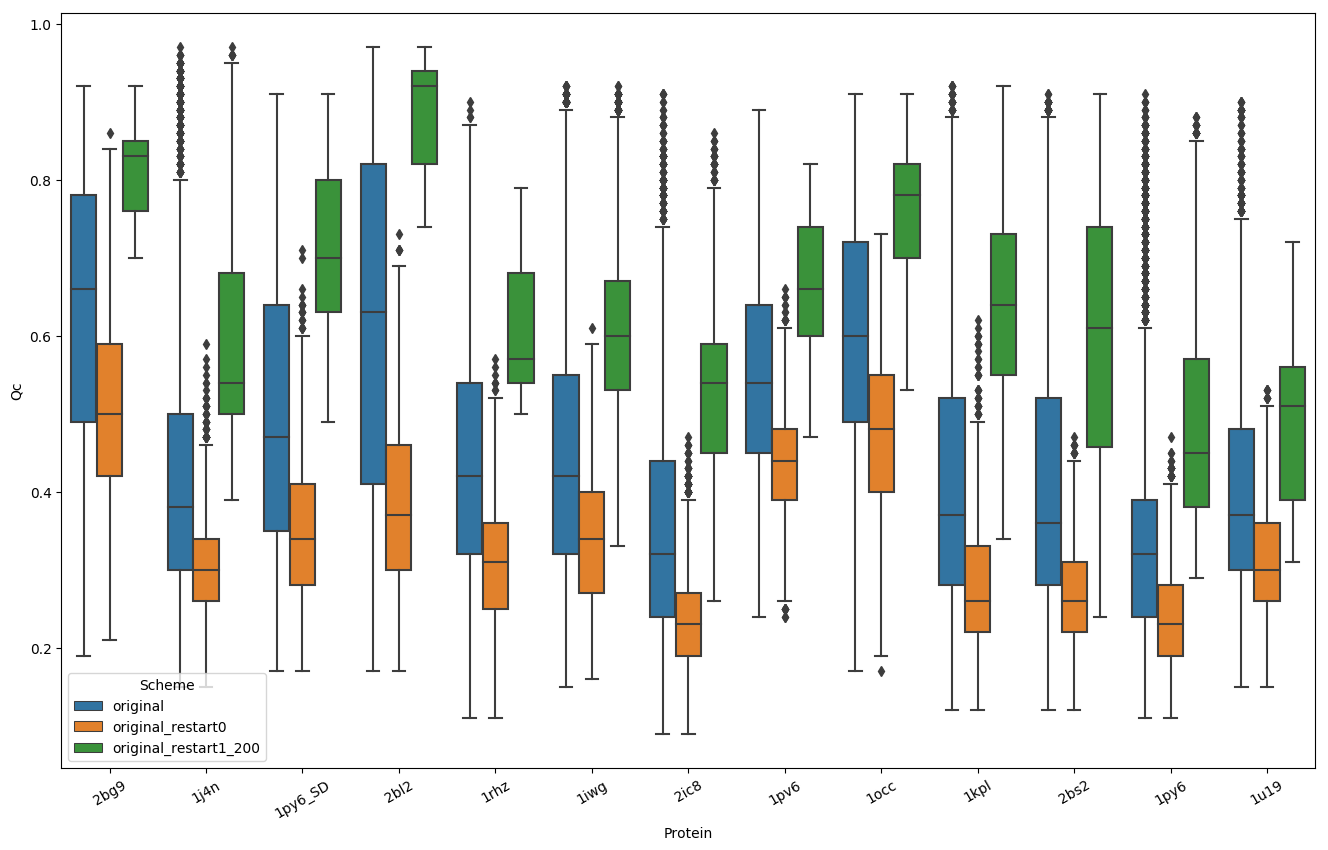

In [19]:
data1 = pd.read_csv("/Users/weilu/Research/data/openMM/openMM_membrane_structure_prediction_original_06-14.csv", index_col=0)

# data2 = pd.read_csv("/Users/weilu/Research/data/openMM/openMM_multiLetter_frags_original_06-04.csv", index_col=0)
# data3 = pd.read_csv("/Users/weilu/Research/data/openMM/openMM_multiLetter_jun02_original_06-03.csv", index_col=0)

d = pd.concat([
#     data3.assign(Scheme="original"), 
    data1.assign(Scheme="original"), 
#     data1.query("Restart == 0").assign(Scheme="original_restart0_all"), 
    data1.query("Steps > 200 and Restart == 0").assign(Scheme="original_restart0"), 
#                 data1.query("Restart == 1").assign(Scheme="original_restart1"), 
    data1.query("Steps > 300 and Restart == 1").assign(Scheme="original_restart1_200"), 
#                 data2.query("Steps > 80 and Restart == 1").assign(Scheme="original"),

              ])
sns.boxplot("Protein", "Qc", hue="Scheme", data=d)
# sns.boxplot("Qw", "Name", hue="Scheme", data=d)
_ = plt.xticks(rotation=30)

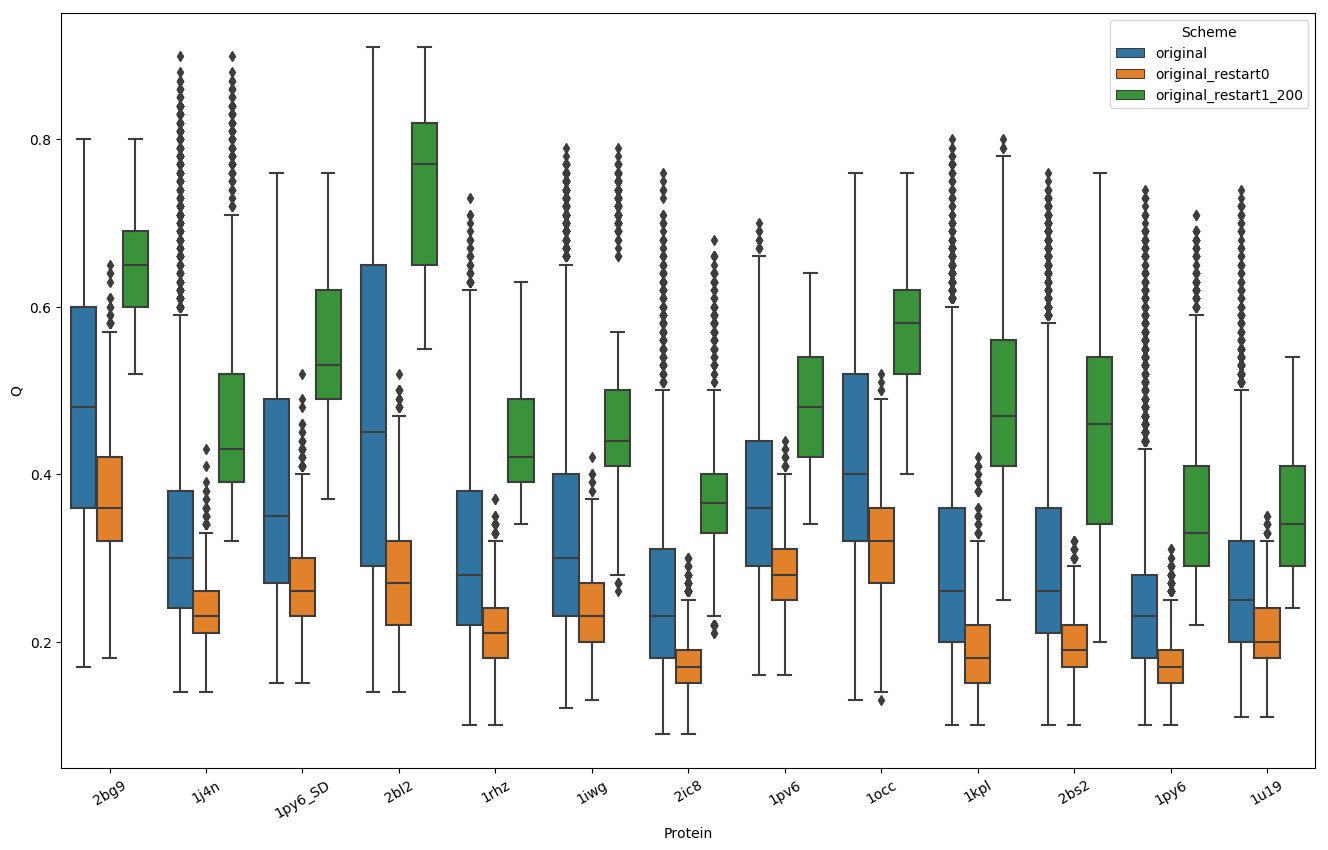

In [18]:
data1 = pd.read_csv("/Users/weilu/Research/data/openMM/openMM_membrane_structure_prediction_original_06-14.csv", index_col=0)

# data2 = pd.read_csv("/Users/weilu/Research/data/openMM/openMM_multiLetter_frags_original_06-04.csv", index_col=0)
# data3 = pd.read_csv("/Users/weilu/Research/data/openMM/openMM_multiLetter_jun02_original_06-03.csv", index_col=0)

d = pd.concat([
#     data3.assign(Scheme="original"), 
    data1.assign(Scheme="original"), 
#     data1.query("Restart == 0").assign(Scheme="original_restart0_all"), 
    data1.query("Steps > 200 and Restart == 0").assign(Scheme="original_restart0"), 
#                 data1.query("Restart == 1").assign(Scheme="original_restart1"), 
    data1.query("Steps > 300 and Restart == 1").assign(Scheme="original_restart1_200"), 
#                 data2.query("Steps > 80 and Restart == 1").assign(Scheme="original"),

              ])
sns.boxplot("Protein", "Q", hue="Scheme", data=d)
# sns.boxplot("Qw", "Name", hue="Scheme", data=d)
_ = plt.xticks(rotation=30)

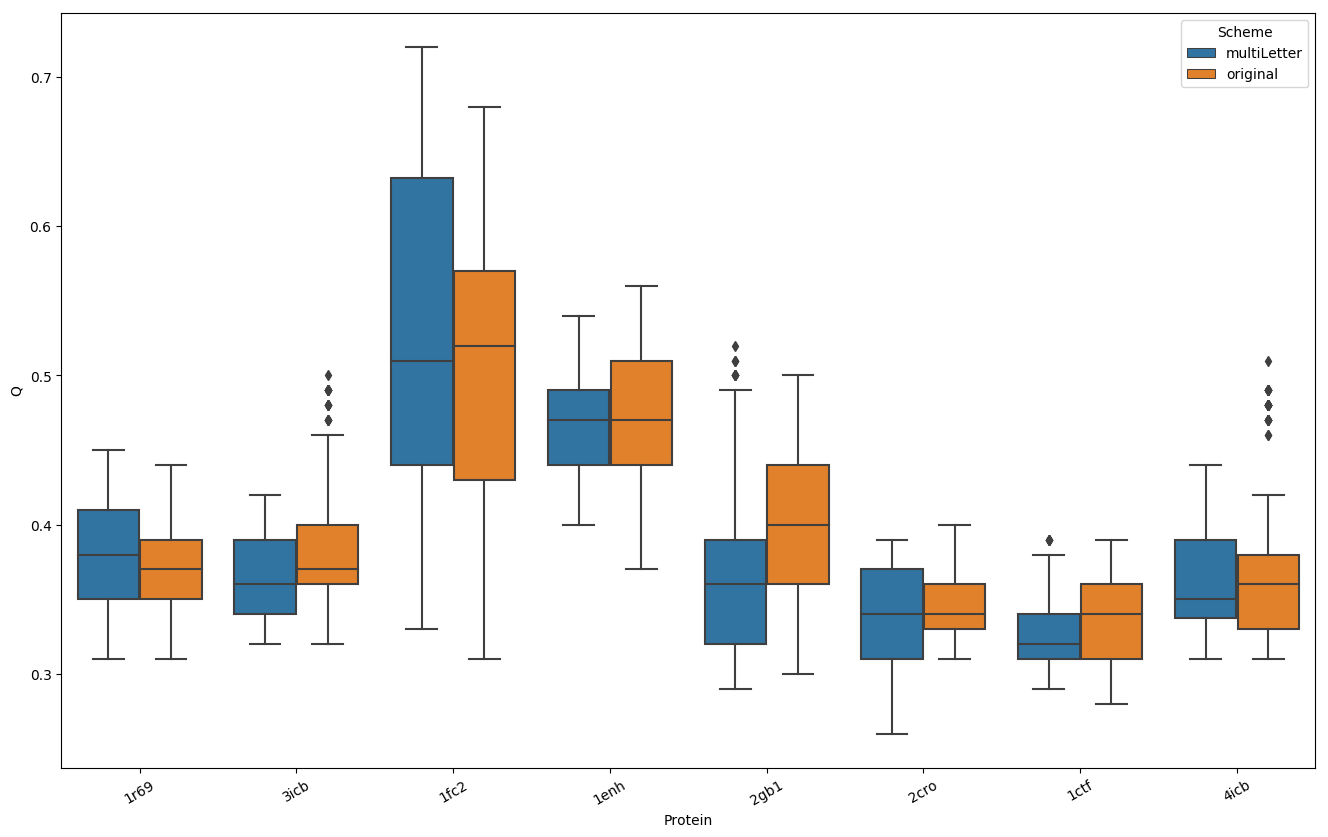

In [154]:
data1 = pd.read_csv("/Users/weilu/Research/data/openMM/openMM_multiLetter_frags_06-04.csv", index_col=0)

data2 = pd.read_csv("/Users/weilu/Research/data/openMM/openMM_multiLetter_frags_original_06-04.csv", index_col=0)
# data3 = pd.read_csv("/Users/weilu/Research/data/openMM/openMM_multiLetter_jun02_original_06-03.csv", index_col=0)

d = pd.concat([
#     data3.assign(Scheme="original"), 
                data1.query("Steps > 80 and Restart == 1").assign(Scheme="multiLetter"), 
                data2.query("Steps > 80 and Restart == 1").assign(Scheme="original"),

              ])
sns.boxplot("Protein", "Q", hue="Scheme", data=d)
# sns.boxplot("Qw", "Name", hue="Scheme", data=d)
_ = plt.xticks(rotation=30)

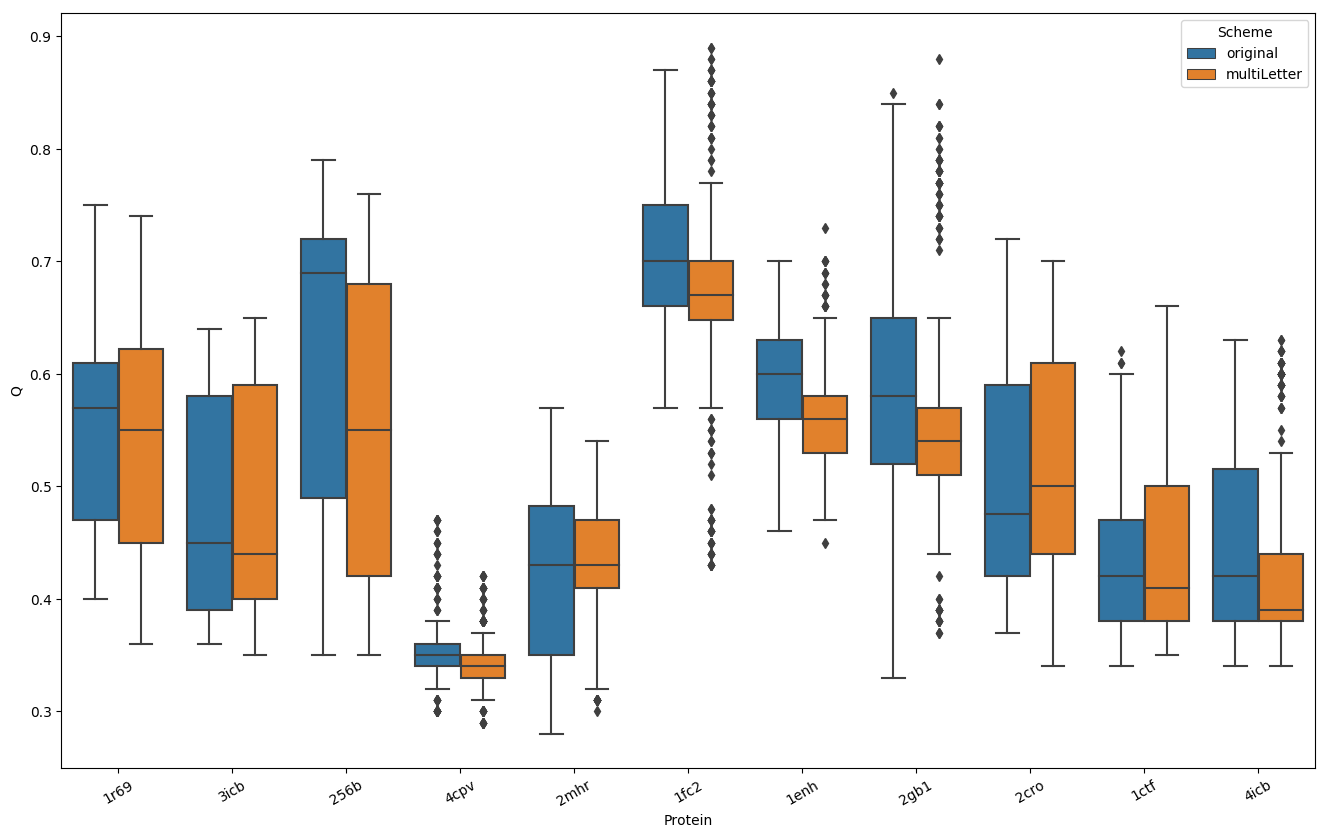

In [156]:
data1 = pd.read_csv("/Users/weilu/Research/data/openMM/openMM_multiLetter_jun02_06-03.csv", index_col=0)

data2 = pd.read_csv("/Users/weilu/Research/data/openMM/openMM_multiLetter_jun03_06-03.csv", index_col=0)
data3 = pd.read_csv("/Users/weilu/Research/data/openMM/openMM_multiLetter_jun02_original_06-03.csv", index_col=0)

d = pd.concat([
    data3.query("Steps > 80 and Restart == 1").assign(Scheme="original"), 
                data1.query("Steps > 80 and Restart == 1").assign(Scheme="multiLetter"), 
#                 data2.assign(Scheme="scheme change"),

              ])
sns.boxplot("Protein", "Q", hue="Scheme", data=d)
# sns.boxplot("Qw", "Name", hue="Scheme", data=d)
_ = plt.xticks(rotation=30)

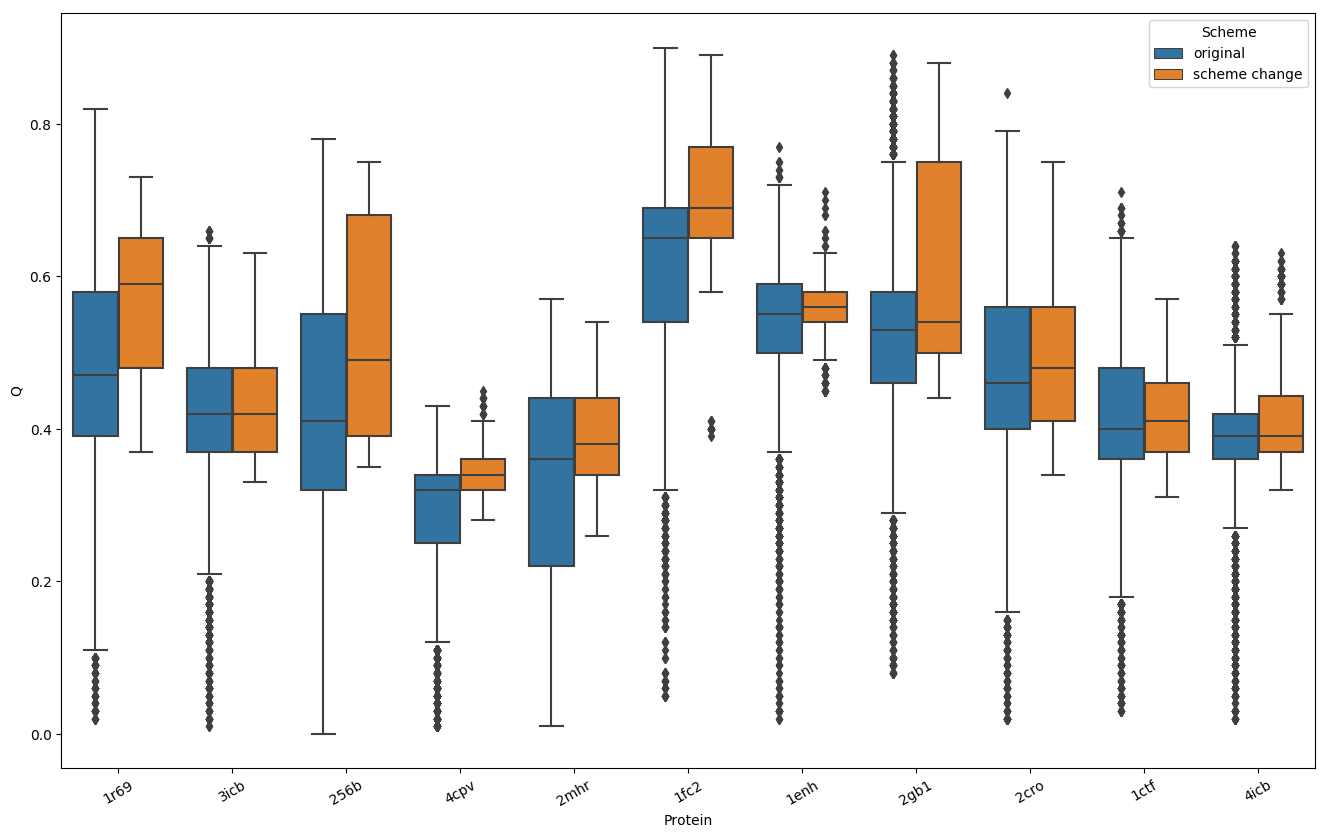

In [136]:
data1 = pd.read_csv("/Users/weilu/Research/data/openMM/openMM_multiLetter_jun02_06-03.csv", index_col=0)

data2 = pd.read_csv("/Users/weilu/Research/data/openMM/openMM_multiLetter_jun03_06-03.csv", index_col=0)

d = pd.concat([
                data1.assign(Scheme="original"), 
                data2.query("Steps > 80 and Restart == 1").assign(Scheme="scheme change"),

              ])
sns.boxplot("Protein", "Q", hue="Scheme", data=d)
# sns.boxplot("Qw", "Name", hue="Scheme", data=d)
_ = plt.xticks(rotation=30)

In [152]:
pdb_list = ['1r69', '3icb', '256b', '4cpv', '2mhr', '1mba', '2fha', '1fc2', '1enh', '2gb1', '2cro', '1ctf', '4icb']
pdb_list = ['1r69', '3icb', '256b', '4cpv', '2mhr', '1fc2', '1enh', '2gb1', '2cro', '1ctf', '4icb']
pdb_list = ['1r69', '3icb', '1fc2', '1enh', '2gb1', '2cro', '1ctf', '4icb']

simulationType = "openMM_multiLetter"
folder = "frags_original"
all_data = []
for pdb in pdb_list:
    for i in range(20):
        for restart in range(2):
            location = f"/Users/weilu/Research/server/may_2019/{simulationType}/{folder}/{pdb}/{i}_{restart}/info.dat"
            try:
                tmp = pd.read_csv(location, sep="\s+")
                tmp = tmp.assign(Run=i, Protein=pdb, Restart=restart)
                all_data.append(tmp)
            except:
                print(pdb, i, restart)
                pass
data = pd.concat(all_data)
today = datetime.today().strftime('%m-%d')
data.reset_index(drop=True).to_csv(f"/Users/weilu/Research/data/openMM/{simulationType}_{folder}_{today}.csv")


In [153]:
pdb_list = ['1r69', '3icb', '256b', '4cpv', '2mhr', '1mba', '2fha', '1fc2', '1enh', '2gb1', '2cro', '1ctf', '4icb']
pdb_list = ['1r69', '3icb', '256b', '4cpv', '2mhr', '1fc2', '1enh', '2gb1', '2cro', '1ctf', '4icb']
pdb_list = ['1r69', '3icb', '1fc2', '1enh', '2gb1', '2cro', '1ctf', '4icb']

simulationType = "openMM_multiLetter"
folder = "frags"
all_data = []
for pdb in pdb_list:
    for i in range(20):
        for restart in range(2):
            location = f"/Users/weilu/Research/server/may_2019/{simulationType}/{folder}/{pdb}/{i}_{restart}/info.dat"
            try:
                tmp = pd.read_csv(location, sep="\s+")
                tmp = tmp.assign(Run=i, Protein=pdb, Restart=restart)
                all_data.append(tmp)
            except:
                print(pdb, i, restart)
                pass
data = pd.concat(all_data)
today = datetime.today().strftime('%m-%d')
data.reset_index(drop=True).to_csv(f"/Users/weilu/Research/data/openMM/{simulationType}_{folder}_{today}.csv")


In [83]:
pdb_list = ['1r69', '3icb', '256b', '4cpv', '2mhr', '1mba', '2fha', '1fc2', '1enh', '2gb1', '2cro', '1ctf', '4icb']
pdb_list = ['1r69', '3icb', '256b', '4cpv', '2mhr', '1fc2', '1enh', '2gb1', '2cro', '1ctf', '4icb']
simulationType = "openMM_multiLetter"
folder = "jun02"
all_data = []
for pdb in pdb_list:
    for i in range(20):
        for restart in range(2):
            location = f"/Users/weilu/Research/server/may_2019/{simulationType}/{folder}/{pdb}/{i}_{restart}/info.dat"
            tmp = pd.read_csv(location, sep="\s+")
            tmp = tmp.assign(Run=i, Protein=pdb, Restart=restart)
            all_data.append(tmp)
data = pd.concat(all_data)
today = datetime.today().strftime('%m-%d')
data.reset_index(drop=True).to_csv(f"/Users/weilu/Research/data/openMM/{simulationType}_{folder}_{today}.csv")


In [101]:
pdb_list = ['1r69', '3icb', '256b', '4cpv', '2mhr', '1mba', '2fha', '1fc2', '1enh', '2gb1', '2cro', '1ctf', '4icb']
pdb_list = ['1r69', '3icb', '256b', '4cpv', '2mhr', '1fc2', '1enh', '2gb1', '2cro', '1ctf', '4icb']
simulationType = "openMM_multiLetter"
folder = "jun02_original"
all_data = []
for pdb in pdb_list:
    for i in range(20):
        for restart in range(2):
            location = f"/Users/weilu/Research/server/may_2019/{simulationType}/{folder}/{pdb}/{i}_{restart}/info.dat"
            tmp = pd.read_csv(location, sep="\s+")
            tmp = tmp.assign(Run=i, Protein=pdb, Restart=restart)
            all_data.append(tmp)
data = pd.concat(all_data)
today = datetime.today().strftime('%m-%d')
data.reset_index(drop=True).to_csv(f"/Users/weilu/Research/data/openMM/{simulationType}_{folder}_{today}.csv")


In [131]:
pdb_list = ['1r69', '3icb', '256b', '4cpv', '2mhr', '1mba', '2fha', '1fc2', '1enh', '2gb1', '2cro', '1ctf', '4icb']
pdb_list = ['1r69', '3icb', '256b', '4cpv', '2mhr', '1fc2', '1enh', '2gb1', '2cro', '1ctf', '4icb']
simulationType = "openMM_multiLetter"
folder = "jun03"
all_data = []
for pdb in pdb_list:
    for i in range(20):
        for restart in range(2):
            location = f"/Users/weilu/Research/server/may_2019/{simulationType}/{folder}/{pdb}/{i}_{restart}/info.dat"
            tmp = pd.read_csv(location, sep="\s+")
            tmp = tmp.assign(Run=i, Protein=pdb, Restart=restart)
            all_data.append(tmp)
data = pd.concat(all_data)
today = datetime.today().strftime('%m-%d')
data.reset_index(drop=True).to_csv(f"/Users/weilu/Research/data/openMM/{simulationType}_{folder}_{today}.csv")


(0, 1)

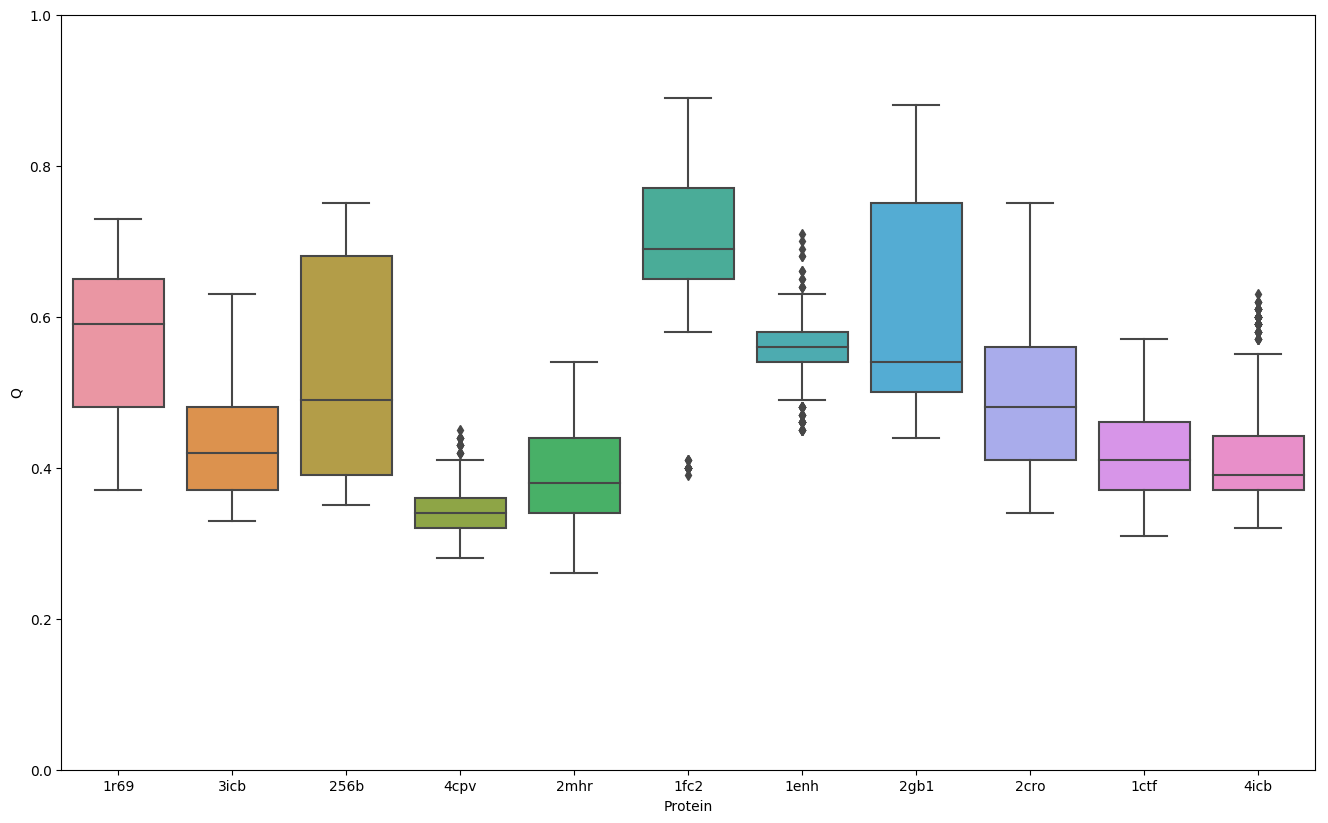

In [133]:
sns.boxplot("Protein", "Q", data=data.query("Steps > 80 and Restart == 1"))
plt.ylim([0,1])

In [79]:
jun02 = data

(0, 1)

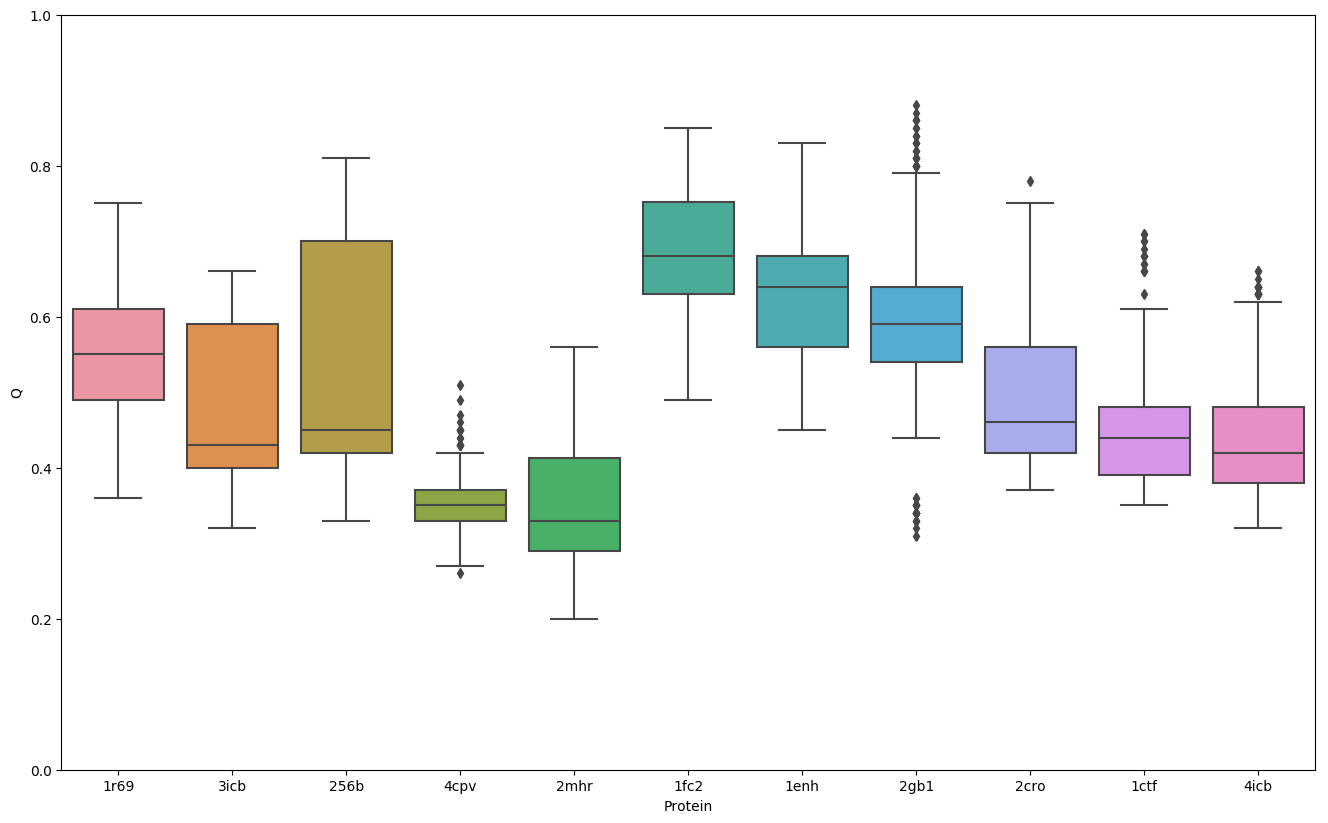

In [86]:
sns.boxplot("Protein", "Q", data=data.query("Steps > 80 and Restart == 0"))
plt.ylim([0,1])

(0, 1)

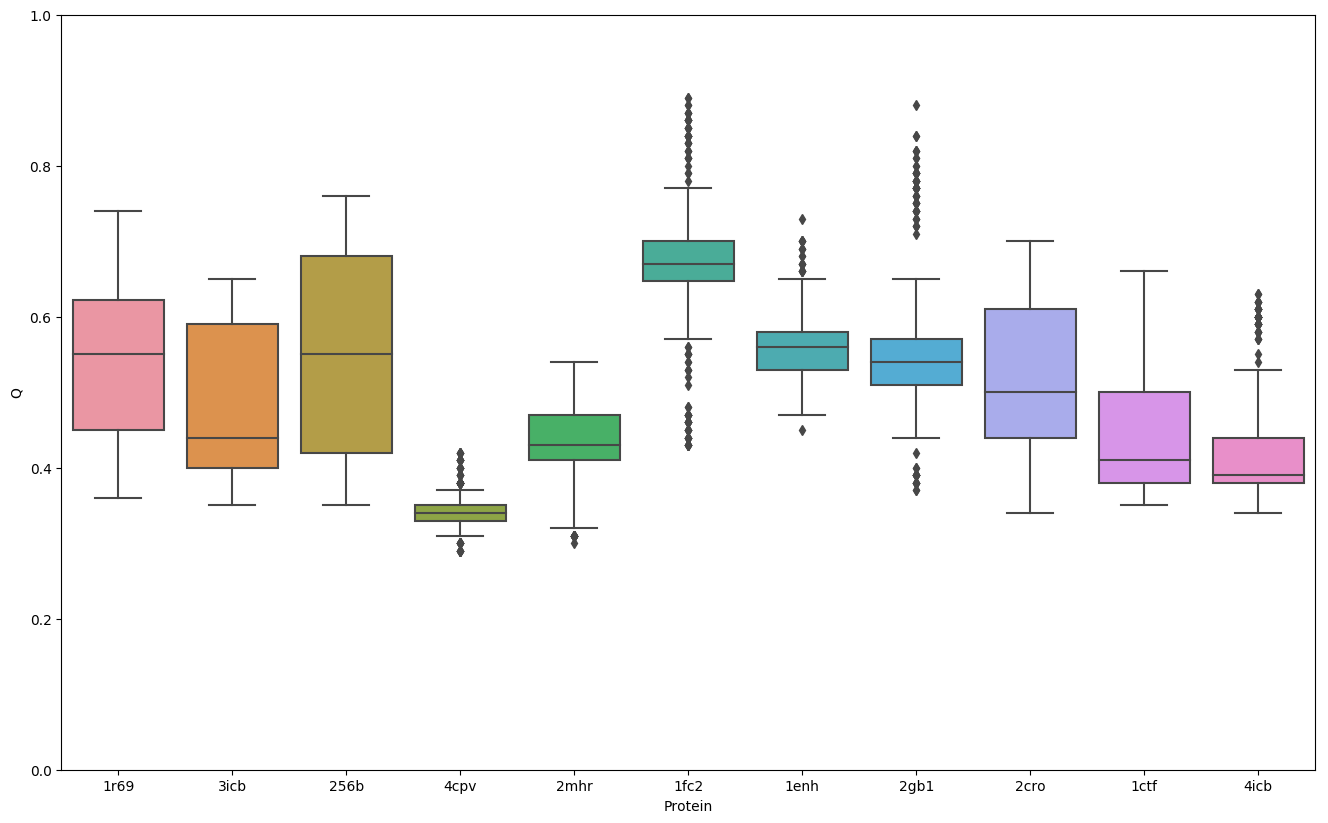

In [77]:
sns.boxplot("Protein", "Q", data=data.query("Steps > 80 and Restart == 1"))
plt.ylim([0,1])

(0, 1)

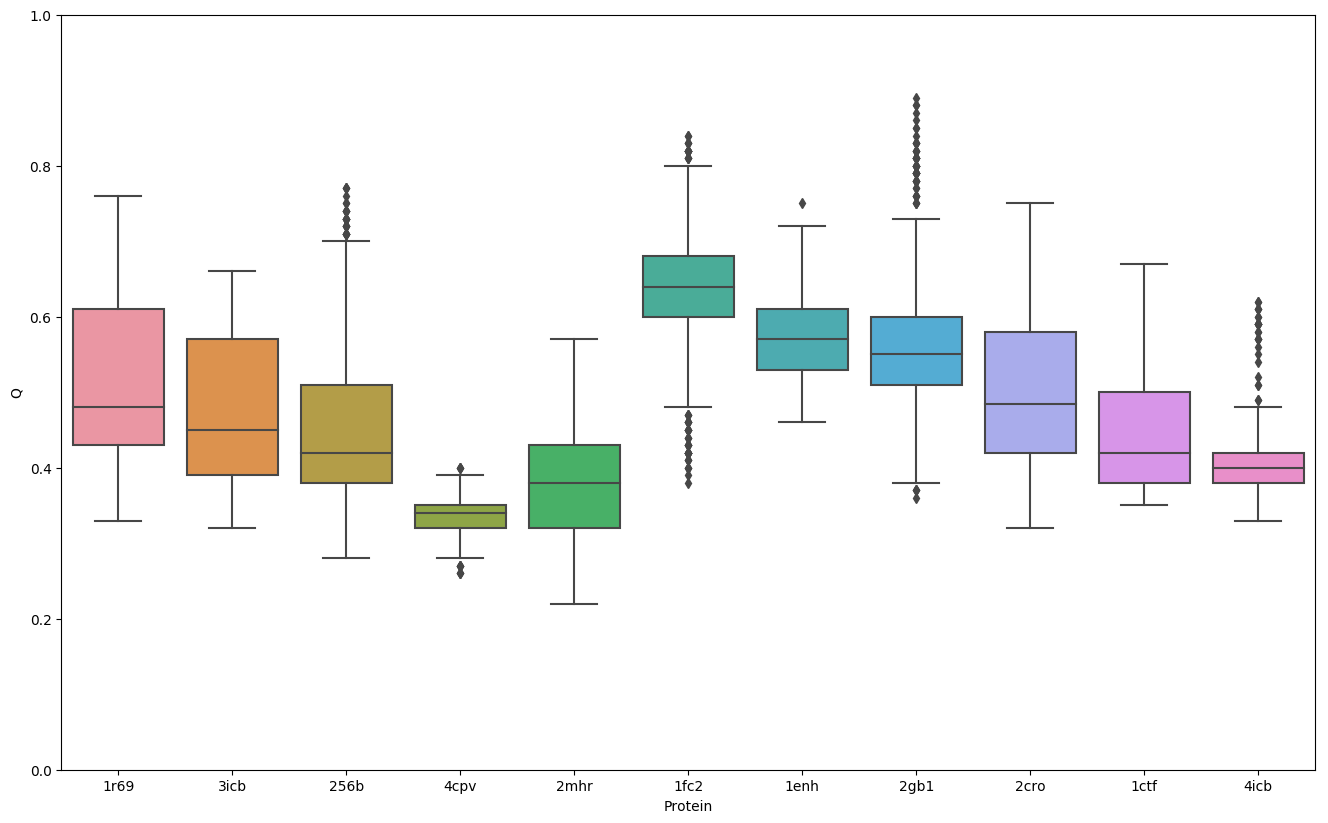

In [78]:
sns.boxplot("Protein", "Q", data=data.query("Steps > 80 and Restart == 0"))
plt.ylim([0,1])

In [20]:
pdb_list = ['1r69', '3icb', '256b', '4cpv', '2mhr', '1mba', '2fha', '1fc2', '1enh', '2gb1', '2cro', '1ctf', '4icb']
all_data = []
for pdb in pdb_list:
    for i in range(20):
        for restart in range(2):
            location = f"/Users/weilu/Research/server/may_2019/openMM_mass/with_restart/{pdb}/{i}_{restart}/info.dat"
            tmp = pd.read_csv(location, sep="\s+")
            tmp = tmp.assign(Run=i, Protein=pdb, Restart=restart)
            all_data.append(tmp)
data = pd.concat(all_data)

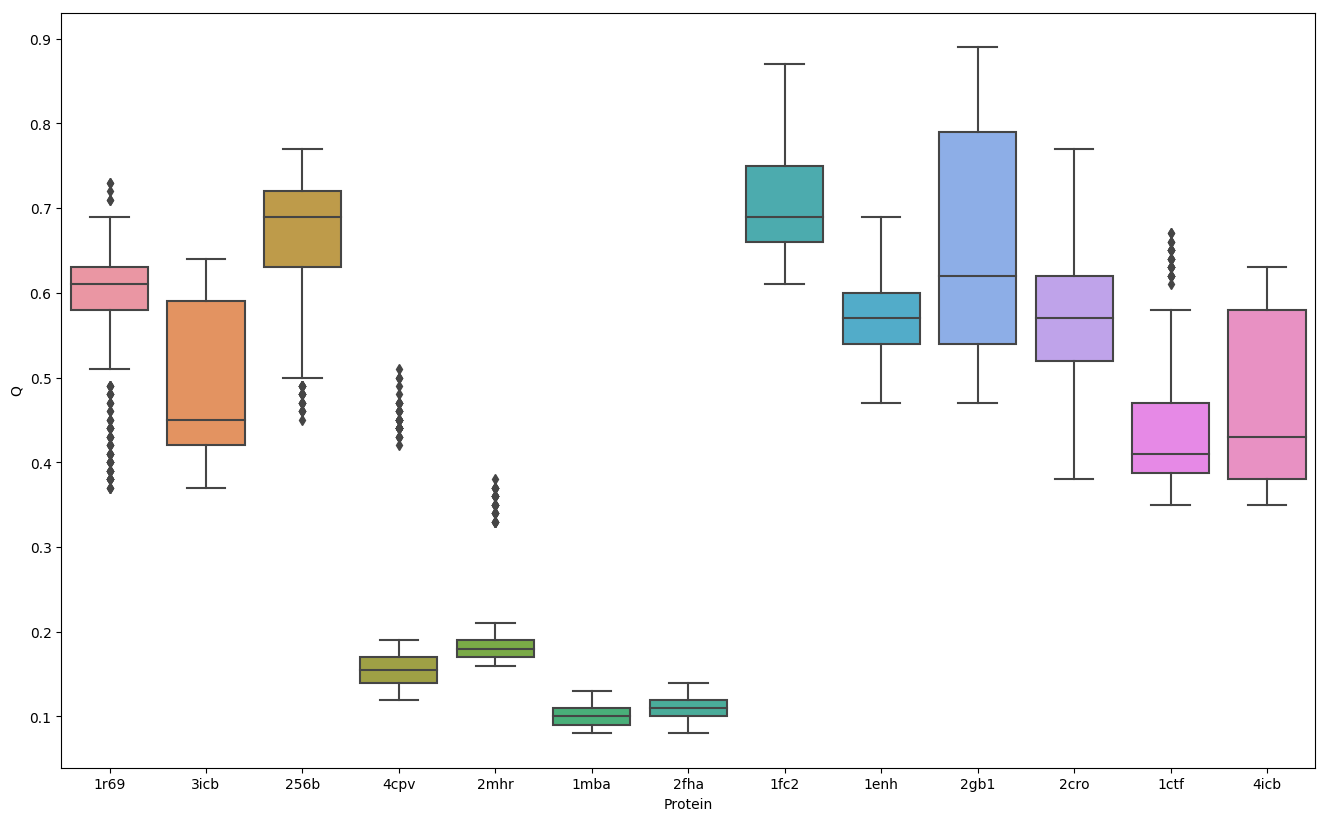

In [23]:
sns.boxplot("Protein", "Q", data=data.query("Steps > 80 and Restart == 1"))

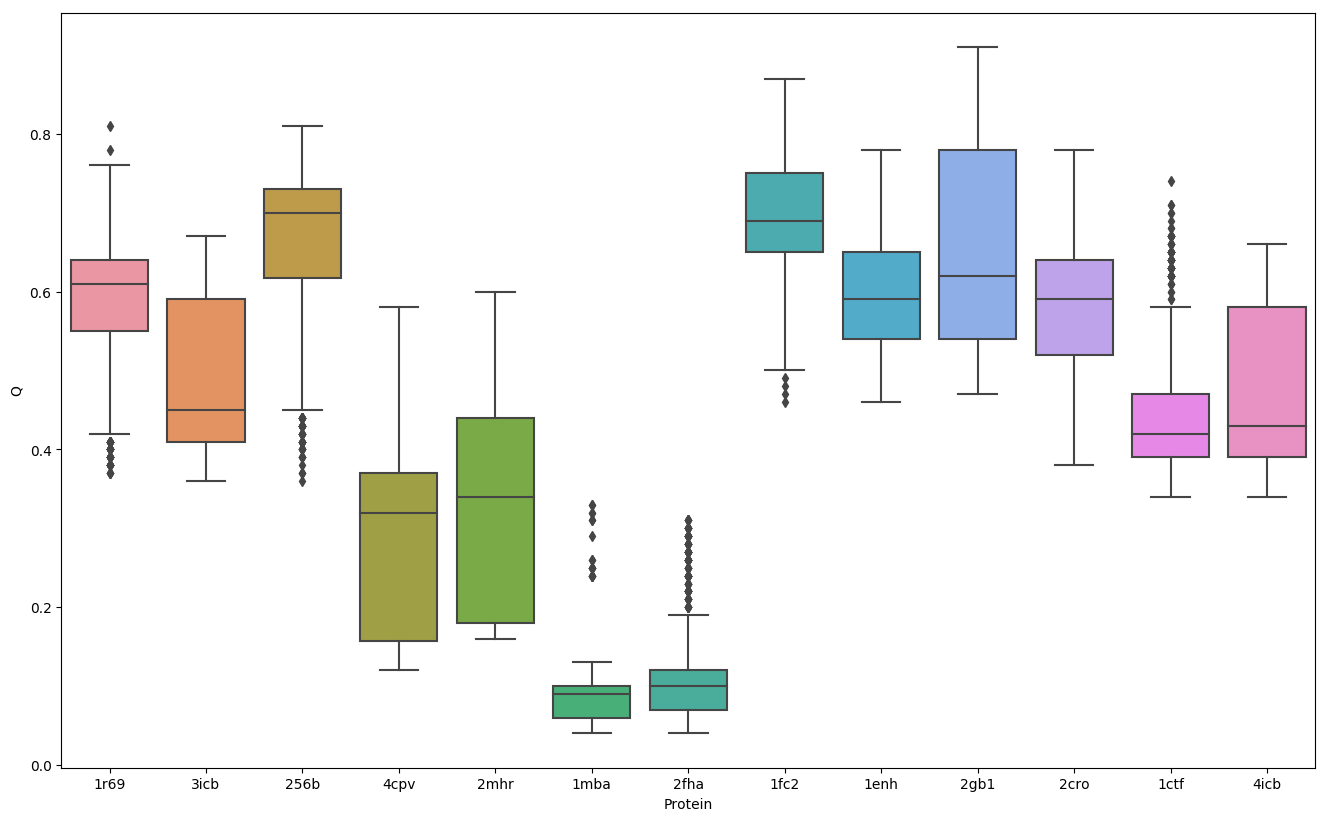

In [22]:
sns.boxplot("Protein", "Q", data=data.query("Steps > 80"))

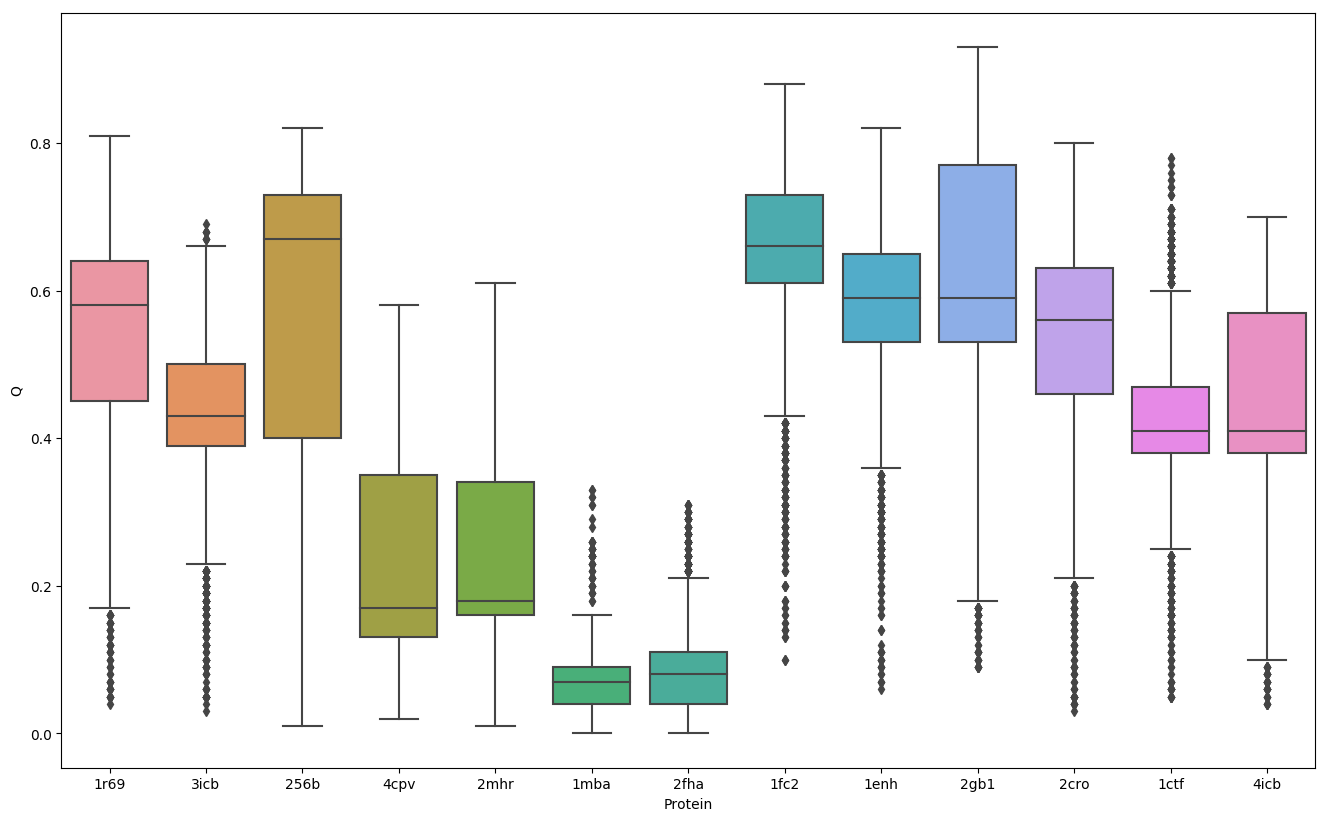

In [21]:
sns.boxplot("Protein", "Q", data=data)

In [8]:
data = pd.read_csv(location, sep="\s+")

In [15]:
pdb_list = ['1r69', '3icb', '256b', '4cpv', '2mhr', '1mba', '2fha', '1fc2', '1enh', '2gb1', '2cro', '1ctf', '4icb']
all_data = []
for pdb in pdb_list:
    for i in range(20):
        location = f"/Users/weilu/Research/server/may_2019/openMM_mass/fast/{pdb}/{i}/info.dat"
        tmp = pd.read_csv(location, sep="\s+")
        tmp = tmp.assign(Run=i, Protein=pdb)
        all_data.append(tmp)
data = pd.concat(all_data)

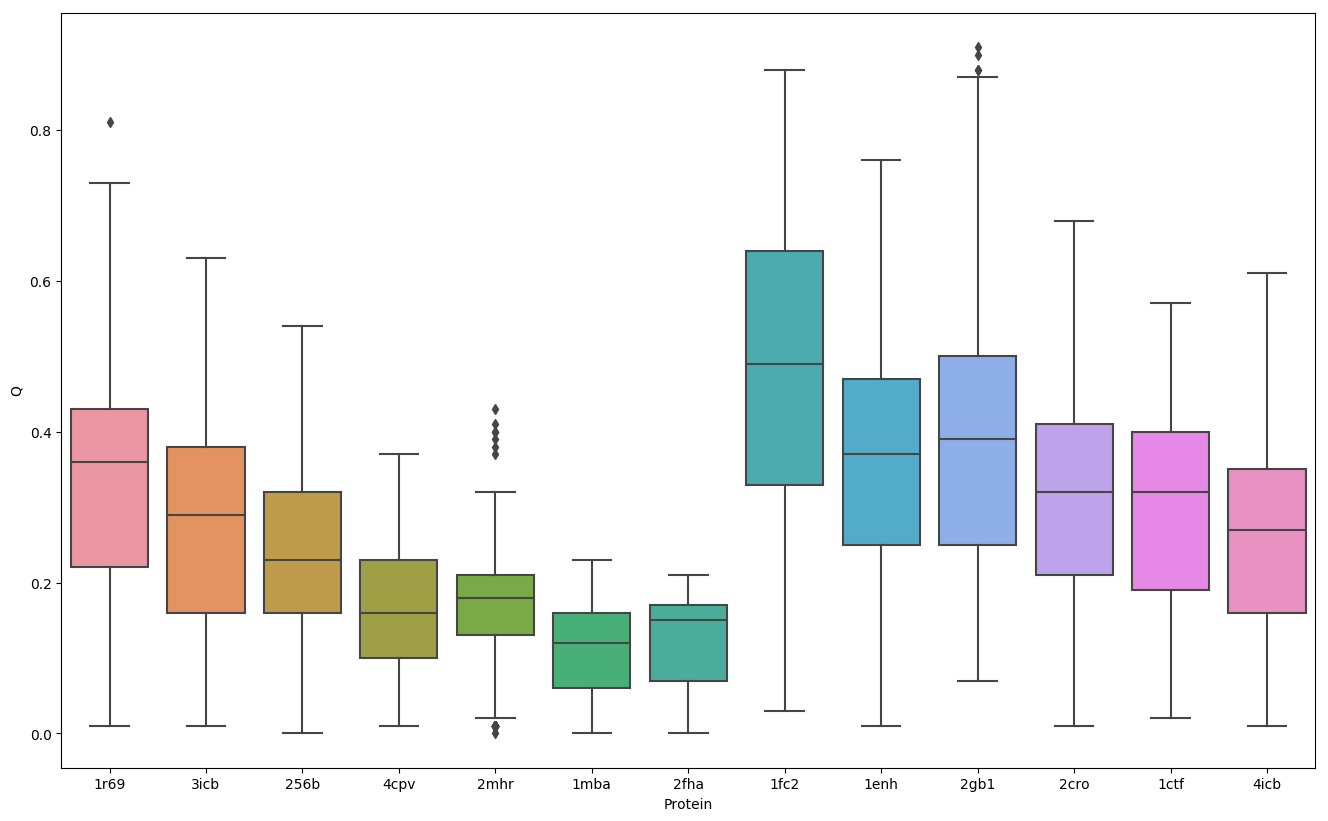

In [19]:
sns.boxplot("Protein", "Q", data=data)

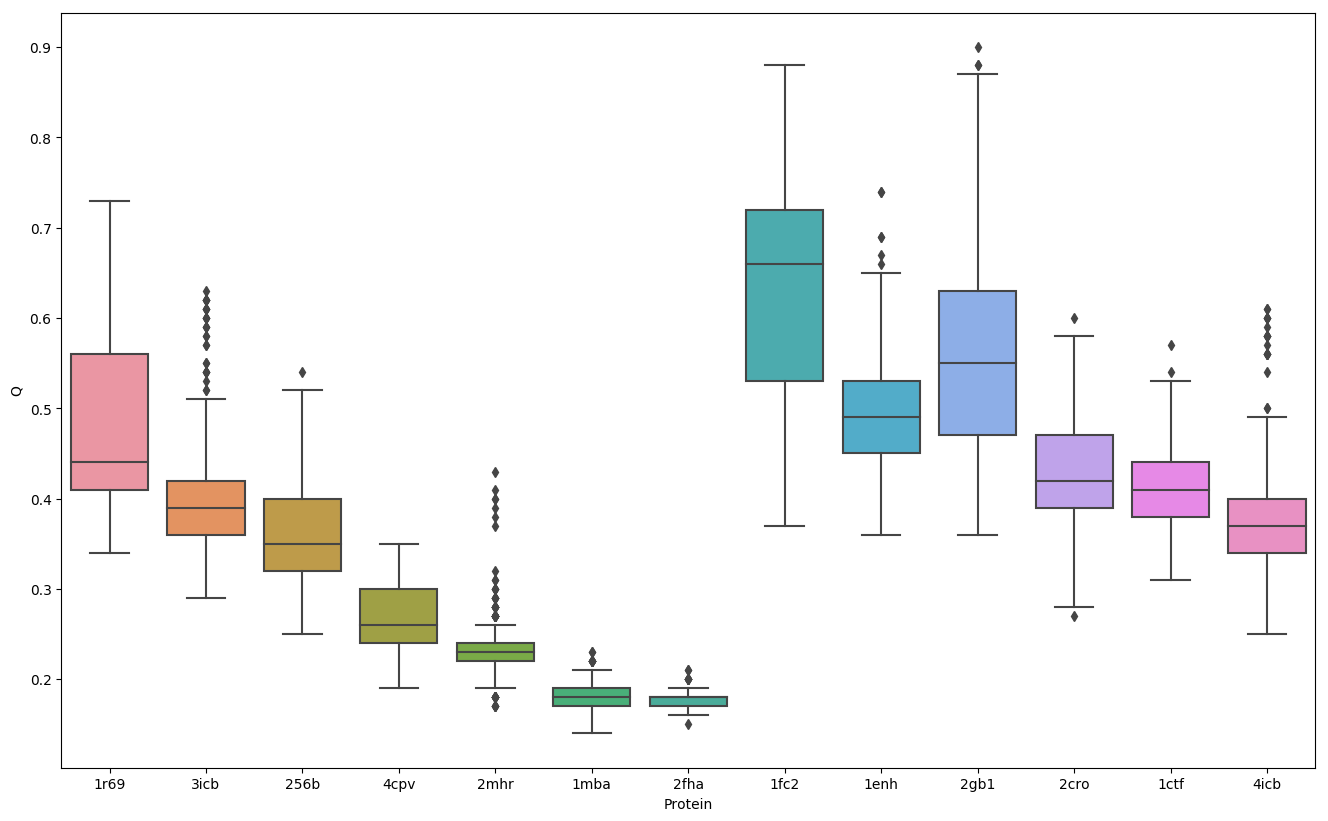

In [18]:
sns.boxplot("Protein", "Q", data=data.query("Steps > 80"))

In [108]:
weight_info = pd.read_csv("~/opt/parameters/amino_acid_side_chain_weight", comment="#", sep="\s+")
weight_info["normalized_weight"] =  weight_info["weight"] /(weight_info["weight"].min())
weight_info

,Name,threeLetterCode,oneLetterCode,Molecular_Weight,Molecular_Formula,Residue_Formula,weight,pKa1,pKb2,pKx3,pl4,normalized_weight
0,Alanine,Ala,A,89.10,C3H7NO2,C3H5NO,71.08,2.34,9.69,–,6.00,1.245925
1,Arginine,Arg,R,174.20,C6H14N4O2,C6H12N4O,156.19,2.17,9.04,12.48,10.76,2.737774
2,Asparagine,Asn,N,132.12,C4H8N2O3,C4H6N2O2,114.11,2.02,8.80,–,5.41,2.000175
3,Aspartic_acid,Asp,D,133.11,C4H7NO4,C4H5NO3,115.09,1.88,9.60,3.65,2.77,2.017353
4,Cysteine,Cys,C,121.16,C3H7NO2S,C3H5NOS,103.15,1.96,10.28,8.18,5.07,1.808063
5,Glutamic_acid,Glu,E,147.13,C5H9NO4,C5H7NO3,129.12,2.19,9.67,4.25,3.22,2.263278
6,Glutamine,Gln,Q,146.15,C5H10N2O3,C5H8N2O2,128.13,2.17,9.13,–,5.65,2.245925
7,Glycine,Gly,G,75.07,C2H5NO2,C2H3NO,57.05,2.34,9.60,–,5.97,1.000000
8,Histidine,His,H,155.16,C6H9N3O2,C6H7N3O,137.14,1.82,9.17,6.00,7.59,2.403856
9,Hydroxyproline,Hyp,O,131.13,C5H9NO3,C5H7NO2,113.11,1.82,9.65,–,–,1.982647


In [129]:
weight_info["sideChainWeight"] = weight_info["weight"] - 56
weight_info["normalized_weight_2"] =  (weight_info["sideChainWeight"]  /(weight_info["sideChainWeight"].min()))


In [130]:
weight_info.sort_values("weight")

,Name,threeLetterCode,oneLetterCode,Molecular_Weight,Molecular_Formula,Residue_Formula,weight,pKa1,pKb2,pKx3,pl4,normalized_weight,sideChainWeight,normalized_weight_2
7,Glycine,Gly,G,75.07,C2H5NO2,C2H3NO,57.05,2.34,9.60,–,5.97,1.000000,1.05,1.000000
0,Alanine,Ala,A,89.10,C3H7NO2,C3H5NO,71.08,2.34,9.69,–,6.00,1.245925,15.08,14.361905
17,Serine,Ser,S,105.09,C3H7NO3,C3H5NO2,87.08,2.21,9.15,–,5.68,1.526380,31.08,29.600000
15,Proline,Pro,P,115.13,C5H9NO2,C5H7NO,97.12,1.99,10.60,–,6.30,1.702366,41.12,39.161905
21,Valine,Val,V,117.15,C5H11NO2,C5H9NO,99.13,2.32,9.62,–,5.96,1.737599,43.13,41.076190
18,Threonine,Thr,T,119.12,C4H9NO3,C4H7NO2,101.11,2.09,9.10,–,5.60,1.772305,45.11,42.961905
4,Cysteine,Cys,C,121.16,C3H7NO2S,C3H5NOS,103.15,1.96,10.28,8.18,5.07,1.808063,47.15,44.904762
9,Hydroxyproline,Hyp,O,131.13,C5H9NO3,C5H7NO2,113.11,1.82,9.65,–,–,1.982647,57.11,54.390476
10,Isoleucine,Ile,I,131.18,C6H13NO2,C6H11NO,113.16,2.36,9.60,–,6.02,1.983523,57.16,54.438095
11,Leucine,Leu,L,131.18,C6H13NO2,C6H11NO,113.16,2.36,9.60,–,5.98,1.983523,57.16,54.438095


In [109]:
weight_info.sort_values("weight")

,Name,threeLetterCode,oneLetterCode,Molecular_Weight,Molecular_Formula,Residue_Formula,weight,pKa1,pKb2,pKx3,pl4,normalized_weight
7,Glycine,Gly,G,75.07,C2H5NO2,C2H3NO,57.05,2.34,9.60,–,5.97,1.000000
0,Alanine,Ala,A,89.10,C3H7NO2,C3H5NO,71.08,2.34,9.69,–,6.00,1.245925
17,Serine,Ser,S,105.09,C3H7NO3,C3H5NO2,87.08,2.21,9.15,–,5.68,1.526380
15,Proline,Pro,P,115.13,C5H9NO2,C5H7NO,97.12,1.99,10.60,–,6.30,1.702366
21,Valine,Val,V,117.15,C5H11NO2,C5H9NO,99.13,2.32,9.62,–,5.96,1.737599
18,Threonine,Thr,T,119.12,C4H9NO3,C4H7NO2,101.11,2.09,9.10,–,5.60,1.772305
4,Cysteine,Cys,C,121.16,C3H7NO2S,C3H5NOS,103.15,1.96,10.28,8.18,5.07,1.808063
9,Hydroxyproline,Hyp,O,131.13,C5H9NO3,C5H7NO2,113.11,1.82,9.65,–,–,1.982647
10,Isoleucine,Ile,I,131.18,C6H13NO2,C6H11NO,113.16,2.36,9.60,–,6.02,1.983523
11,Leucine,Leu,L,131.18,C6H13NO2,C6H11NO,113.16,2.36,9.60,–,5.98,1.983523


In [105]:
float(weight_info.query(f"threeLetterCode == '{Ala}'")["normalized_weight"])

1.2459246275197196

In [119]:
r = np.linspace(0, 30)
y = interaction_well(r, 6, 9, 4)

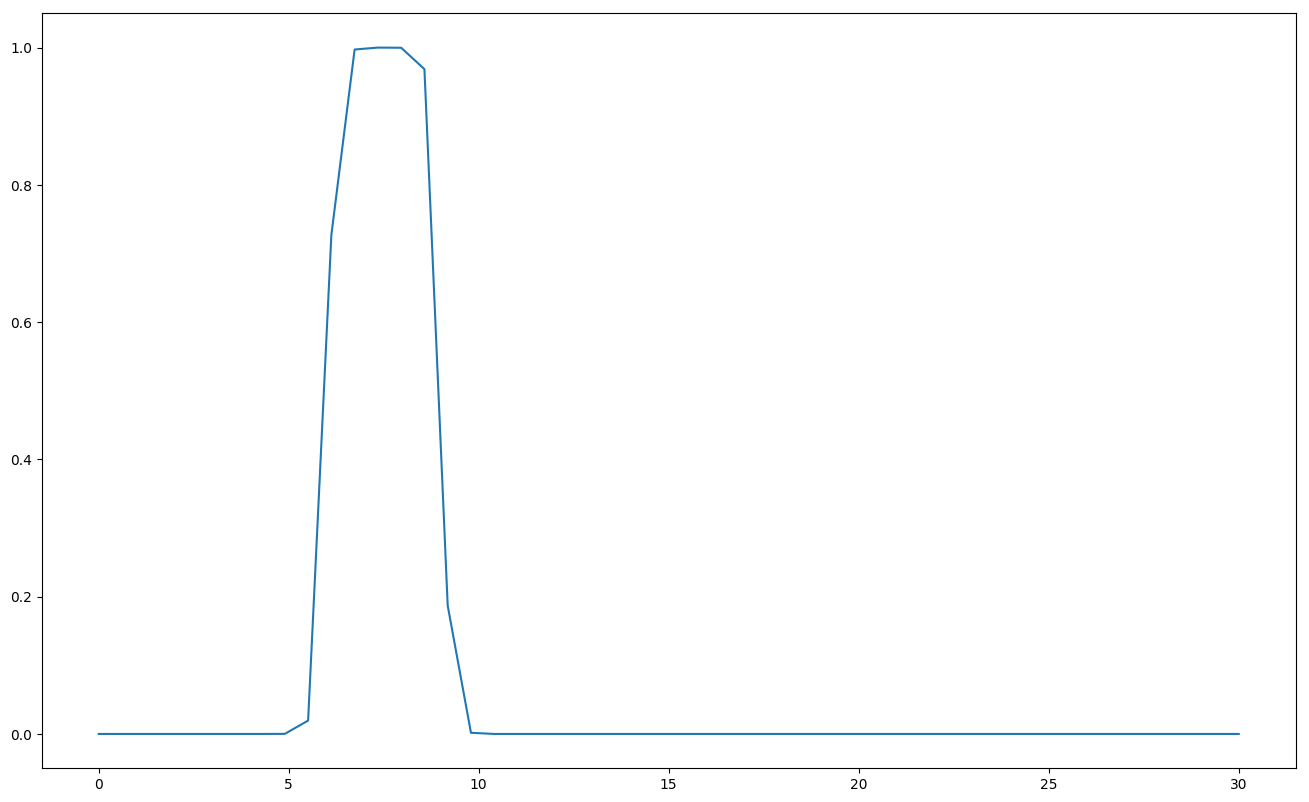

In [120]:
plt.plot(r,y)

In [111]:
interaction_well(20, 6, 9, 4)

0.0

In [ ]:
interaction_well(res1density, rho_table[i][0], rho_table[i][1], kappa)

In [107]:
res2type = "ala"
f"threeLetterCode == '{res2type}'"

"threeLetterCode == 'ala'"

In [106]:
print(f"threeLetterCode == '{res2type}'")

NameError: name 'res2type' is not defined

In [16]:
data.columns

Index(['Steps', 'Q', 'Rg', 'Con', 'Chain', 'Chi', 'Excluded', 'Rama',
       'Contact', 'FamilyFold', 'Fragment', 'Membrane', 'Beta', 'Pap',
       'Rg_Bias', 'Total', 'Run', 'Protein'],
      dtype='object')

In [13]:
data

,Steps,Q,Rg,Con,Chain,Chi,Excluded,Rama,Contact,FamilyFold,Fragment,Membrane,Beta,Pap,Rg_Bias,Total
0,0,0.01,0.0,194.83,114.49,39.43,3.37,-80.57,-48.73,0.0,-52.04,0.0,-0.00,0.00,0.0,170.77
1,1,0.04,0.0,180.09,129.51,31.61,0.70,-96.87,-49.17,0.0,-116.81,0.0,-0.00,0.00,0.0,79.05
2,2,0.04,0.0,204.70,119.15,36.27,6.84,-60.66,-47.67,0.0,-133.00,0.0,-0.00,0.00,0.0,125.62
3,3,0.07,0.0,204.72,116.95,31.39,6.79,-94.05,-54.07,0.0,-173.85,0.0,-0.01,0.00,0.0,37.88
4,4,0.09,0.0,182.66,112.59,36.00,2.75,-78.70,-52.98,0.0,-219.14,0.0,-0.04,0.00,0.0,-16.87
5,5,0.10,0.0,198.69,114.13,42.22,2.19,-84.36,-48.42,0.0,-233.75,0.0,-0.00,0.00,0.0,-9.29
6,6,0.10,0.0,191.94,96.58,25.35,4.58,-79.51,-49.49,0.0,-239.83,0.0,-0.00,0.00,0.0,-50.38
7,7,0.13,0.0,207.07,128.82,31.46,10.68,-95.02,-53.58,0.0,-273.46,0.0,-0.00,0.00,0.0,-44.02
8,8,0.14,0.0,161.63,121.34,22.46,7.33,-87.56,-56.36,0.0,-273.26,0.0,-0.04,0.00,0.0,-104.46
9,9,0.13,0.0,135.93,104.89,30.36,0.68,-96.24,-53.37,0.0,-234.12,0.0,-0.17,-0.00,0.0,-112.04


In [4]:
a = glob.glob("/Users/weilu/Research/server/may_2019/multi_iter0/multiLetter/sub_gamma/*_A")

In [5]:
len(a)

316

In [11]:
i = 0
location = f"/Users/weilu/Research/server/may_2019/multi_iter0/multiLetter/proteins_name_list/proteins_name_list_{i}.txt"


In [12]:
with open(location, "r") as f:
    a = f.readlines()

In [14]:
len(a)

5

In [18]:
i = 0
location = f"/Users/weilu/Research/server/may_2019/multi_iter0/multiLetter/proteins_name_list/proteins_name_list_{i}.txt"
with open(location, "r") as f:
    a = f.readlines()
size = len(a)
# print(size)
pre = "/Users/weilu/Research/server/may_2019/multi_iter0/multiLetter/sub_gamma"
base = pre + f"/proteins_name_list_{i}_phi_pairwise_contact_multiLetter_well4.5_6.5_5.0_10phi_density_mediated_contact_multiLetter_well6.5_9.5_5.0_10_2.6_7.0phi_burial_multiLetter_well4.0"
a_name = base + "_A"
a_prime_name = base + "_A_prime"
std_half_b_name = base + "_std_half_B"
half_b = base + "_half_B"
other_half_b = base + "_other_half_B"

A = size * np.loadtxt(a_name)
A_prime = size * np.loadtxt(a_prime_name)
std_half_B = np.loadtxt(std_half_b_name)
half_B = np.loadtxt(half_b)
other_half_B = np.loadtxt(other_half_b)

    

In [19]:
count = 1
for i in range(1, 362):
    location = f"/Users/weilu/Research/server/may_2019/multi_iter0/multiLetter/proteins_name_list/proteins_name_list_{i}.txt"
    with open(location, "r") as f:
        a = f.readlines()
    size = len(a)
    # print(size)
    pre = "/Users/weilu/Research/server/may_2019/multi_iter0/multiLetter/sub_gamma"
    base = pre + f"/proteins_name_list_{i}_phi_pairwise_contact_multiLetter_well4.5_6.5_5.0_10phi_density_mediated_contact_multiLetter_well6.5_9.5_5.0_10_2.6_7.0phi_burial_multiLetter_well4.0"
    a_name = base + "_A"
    a_prime_name = base + "_A_prime"
    std_half_b_name = base + "_std_half_B"
    half_b = base + "_half_B"
    other_half_b = base + "_other_half_B"
    try:
        A += size * np.loadtxt(a_name)
        A_prime += size * np.loadtxt(a_prime_name)
        std_half_B = np.loadtxt(std_half_b_name)
        half_B += np.loadtxt(half_b)
        other_half_B += np.loadtxt(other_half_b)
        count += 1
    except:
        print(i)
    

84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131


In [21]:
pre = "/Users/weilu/Research/server/may_2019/multi_iter0/multiLetter/gammas/"
n = count*5
A /= n
A_prime /= n
std_half_B /= n
half_B /= n
other_half_B /= n

np.save(pre+ "A", A)
np.save(pre+ "A_prime", A_prime)
np.save(pre+ "std_half_B", std_half_B)
np.save(pre+ "half_B", half_B)
np.save(pre+ "other_half_B", other_half_B)

In [24]:
pre = "/Users/weilu/Research/server/may_2019/multi_iter0/multiLetter/gammas/"


In [25]:
pre = "/Users/weilu/Research/server/may_2019/multi_iter0/multiLetter/gammas/"


In [26]:
pre = "/Users/weilu/Research/server/may_2019/multi_iter0/multiLetter/gammas/"


In [44]:
n = 314*5
A /= n
A_prime /= n
std_half_B /= n
half_B /= n
other_half_B /= n

In [46]:
B = half_B - other_half_B
gamma = np.dot(np.linalg.pinv(B), A)

In [47]:
gamma

array([ 0.64328957,  0.24113237,  0.65962484, ..., -1.480116  ,
       -1.34551388, -1.80250959])

In [48]:
lamb, P = np.linalg.eig(B)
lamb, P = sort_eigenvalues_and_eigenvectors(lamb, P)

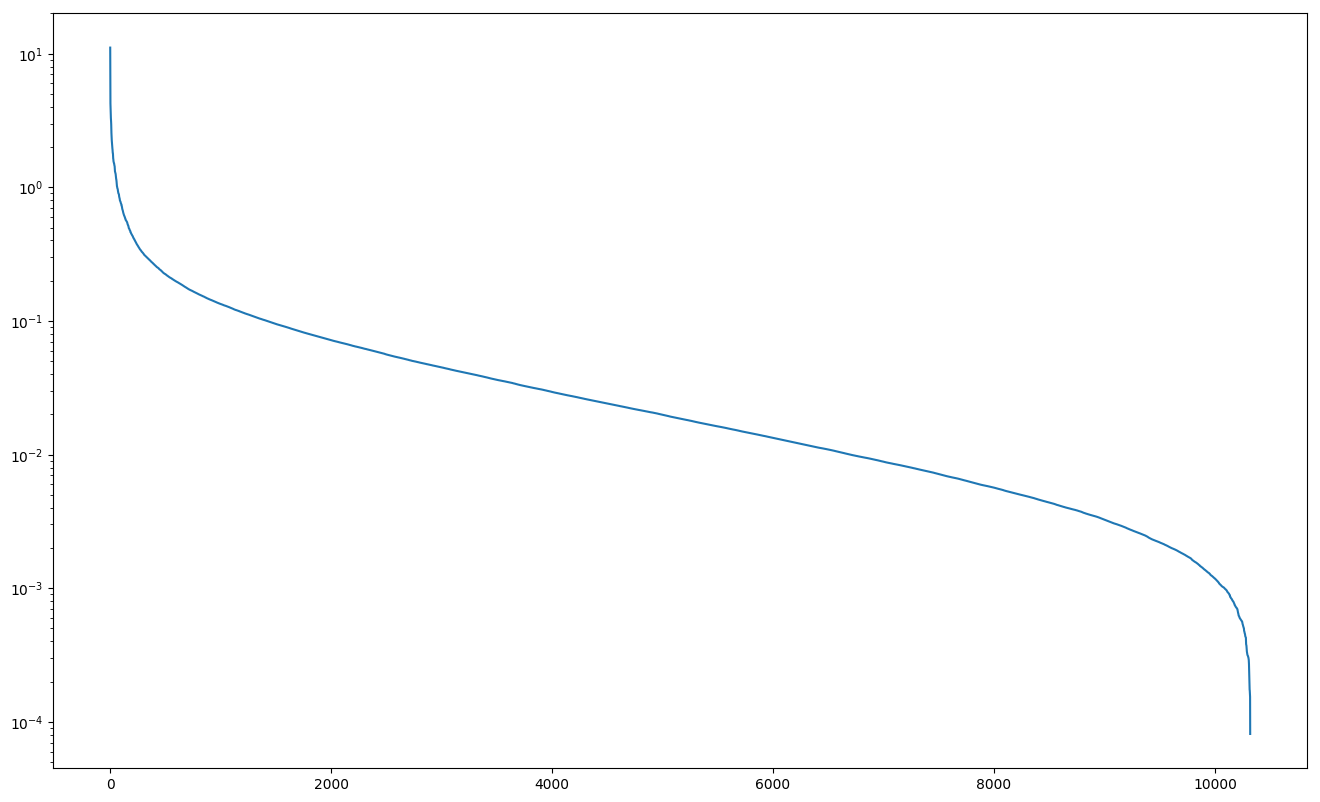

In [50]:
plt.plot(lamb)
plt.yscale("log")

In [52]:
cutoff_mode = 10000
filtered_lamb = np.copy(lamb)
filtered_B_inv, filtered_lamb, P = get_filtered_B_inv_lambda_and_P(
    filtered_lamb, cutoff_mode, P)

filtered_gamma = np.dot(filtered_B_inv, A)

In [60]:
filtered_gamma

array([ 0.6478075 ,  0.24215223,  0.66306092, ..., -1.23498547,
       -1.10785662, -1.56726851])

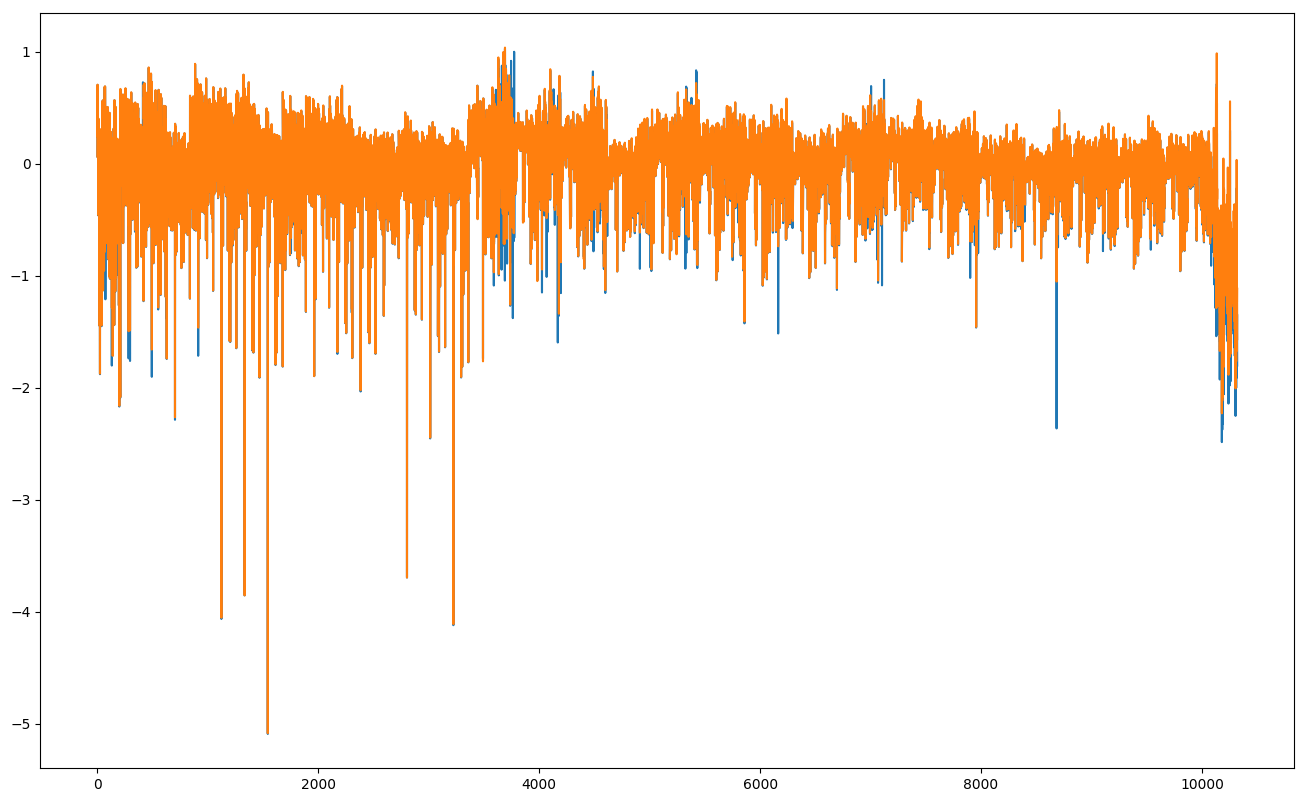

In [55]:
plt.plot(gamma)
plt.plot(filtered_gamma)

In [59]:
pre = "/Users/weilu/Research/server/may_2019/multi_iter0/multiLetter/gammas/"
np.save(pre+ "filtered_gamma", filtered_gamma)

In [63]:

pre = "/Users/weilu/Research/server/may_2019/multi_iter0/multiLetter/gammas/"
g = np.load(pre+ "filtered_gamma.npy")

In [66]:
210*16*3+60*4

10320

In [67]:
g.shape

(10320,)

In [68]:
A.dot(g)

47.32676736227599

In [70]:
A.dot(g)/(g.dot(B).dot(g))**0.5

6.8836276701572805

In [ ]:
iteration_gamma = 
gamma_for_simulation = "/Users/weilu/Research/server/may_2019/openMM_multiLetter/"
from Bio.PDB.Polypeptide import one_to_three, three_to_one
res_type_map = {
    'A': 0,
    'C': 4,
    'D': 3,
    'E': 6,
    'F': 13,
    'G': 7,
    'H': 8,
    'I': 9,
    'K': 11,
    'L': 10,
    'M': 12,
    'N': 2,
    'P': 14,
    'Q': 5,
    'R': 1,
    'S': 15,
    'T': 16,
    'V': 19,
    'W': 17,
    'Y': 18
}
# res_type_map = gamma_se_map_1_letter = {   'A': 0,  'R': 1,  'N': 2,  'D': 3,  'C': 4,
#                             'Q': 5,  'E': 6,  'G': 7,  'H': 8,  'I': 9,
#                             'L': 10, 'K': 11, 'M': 12, 'F': 13, 'P': 14,
#                             'S': 15, 'T': 16, 'W': 17, 'Y': 18, 'V': 19}
res_type_map_letters = ['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G',
                        'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V']

inverse_res_type_map = dict(list(zip(list(range(20)), res_type_map_letters)))

# gamma_location = "/Users/weilu/Research/server_backup/jan_2019/optimization/gammas_dec30/cath-dataset-nonredundant-S20Clean_phi_pairwise_contact_well4.5_6.5_5.0_10phi_density_mediated_contact_well6.5_9.5_5.0_10_2.6_7.0_gamma"
# gamma_for_simulation = "/Users/weilu/Research/server_backup/jan_2019/optimization/iteration_gamma.dat"
gamma = iteration_gamma
gamma = -gamma  # caused by tradition.
# convert gamma to gamma used by simulation
with open(gamma_for_simulation, "w") as out:
    c = 0
    for i in range(20):
        for j in range(i, 20):
            out.write(f"{gamma[c]:<.5f} {gamma[c]:10.5f}\n")
            c += 1
    out.write("\n")
    for i in range(20):
        for j in range(i, 20):
            # protein, water
            out.write(f"{gamma[c]:<.5f} {gamma[c+210]:10.5f}\n")
            c += 1
if burial_gamma_for_simulation:
    rhoGamma = pd.DataFrame(gamma[630:].reshape(3,20).T, columns=["rho1", "rho2", "rho3"]).reset_index()
    rhoGamma["oneLetter"] = rhoGamma["index"].apply(lambda x: inverse_res_type_map[x])
    rhoGamma["Residue"] = rhoGamma["index"].apply(lambda x: one_to_three(inverse_res_type_map[x]))
    rhoGamma = rhoGamma[["Residue", "rho1", "rho2", "rho3", "index", "oneLetter"]]
    g = rhoGamma[["rho1", "rho2", "rho3"]].values
    np.savetxt(burial_gamma_for_simulation, g, fmt='%7.4f')


In [ ]:
def gamma_format_convertion_iteration_to_simulation(iteration_gamma, gamma_for_simulation, burial_gamma_for_simulation=None):
    from Bio.PDB.Polypeptide import one_to_three, three_to_one
    res_type_map = {
        'A': 0,
        'C': 4,
        'D': 3,
        'E': 6,
        'F': 13,
        'G': 7,
        'H': 8,
        'I': 9,
        'K': 11,
        'L': 10,
        'M': 12,
        'N': 2,
        'P': 14,
        'Q': 5,
        'R': 1,
        'S': 15,
        'T': 16,
        'V': 19,
        'W': 17,
        'Y': 18
    }
    # res_type_map = gamma_se_map_1_letter = {   'A': 0,  'R': 1,  'N': 2,  'D': 3,  'C': 4,
    #                             'Q': 5,  'E': 6,  'G': 7,  'H': 8,  'I': 9,
    #                             'L': 10, 'K': 11, 'M': 12, 'F': 13, 'P': 14,
    #                             'S': 15, 'T': 16, 'W': 17, 'Y': 18, 'V': 19}
    res_type_map_letters = ['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G',
                            'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V']

    inverse_res_type_map = dict(list(zip(list(range(20)), res_type_map_letters)))

    # gamma_location = "/Users/weilu/Research/server_backup/jan_2019/optimization/gammas_dec30/cath-dataset-nonredundant-S20Clean_phi_pairwise_contact_well4.5_6.5_5.0_10phi_density_mediated_contact_well6.5_9.5_5.0_10_2.6_7.0_gamma"
    # gamma_for_simulation = "/Users/weilu/Research/server_backup/jan_2019/optimization/iteration_gamma.dat"
    gamma = iteration_gamma
    gamma = -gamma  # caused by tradition.
    # convert gamma to gamma used by simulation
    with open(gamma_for_simulation, "w") as out:
        c = 0
        for i in range(20):
            for j in range(i, 20):
                out.write(f"{gamma[c]:<.5f} {gamma[c]:10.5f}\n")
                c += 1
        out.write("\n")
        for i in range(20):
            for j in range(i, 20):
                # protein, water
                out.write(f"{gamma[c]:<.5f} {gamma[c+210]:10.5f}\n")
                c += 1
    if burial_gamma_for_simulation:
        rhoGamma = pd.DataFrame(gamma[630:].reshape(3,20).T, columns=["rho1", "rho2", "rho3"]).reset_index()
        rhoGamma["oneLetter"] = rhoGamma["index"].apply(lambda x: inverse_res_type_map[x])
        rhoGamma["Residue"] = rhoGamma["index"].apply(lambda x: one_to_three(inverse_res_type_map[x]))
        rhoGamma = rhoGamma[["Residue", "rho1", "rho2", "rho3", "index", "oneLetter"]]
        g = rhoGamma[["rho1", "rho2", "rho3"]].values
        np.savetxt(burial_gamma_for_simulation, g, fmt='%7.4f')


In [57]:
A_prime.dot(filtered_gamma)

-143.4951120018076

In [43]:
314*5

1570

In [28]:
a = 5
try:
    a += 1
    b = 0/0
except:
    print(1)

1


In [31]:
count = 1
a_ = []
for i in range(1, 362):
    location = f"/Users/weilu/Research/server/may_2019/multi_iter0/multiLetter/proteins_name_list/proteins_name_list_{i}.txt"
    with open(location, "r") as f:
        a = f.readlines()
    size = len(a)
    # print(size)
    pre = "/Users/weilu/Research/server/may_2019/multi_iter0/multiLetter/sub_gamma"
    base = pre + f"/proteins_name_list_{i}_phi_pairwise_contact_multiLetter_well4.5_6.5_5.0_10phi_density_mediated_contact_multiLetter_well6.5_9.5_5.0_10_2.6_7.0phi_burial_multiLetter_well4.0"
    a_name = base + "_A"
    a_prime_name = base + "_A_prime"
    std_half_b_name = base + "_std_half_B"
    half_b = base + "_half_B"
    other_half_b = base + "_other_half_B"
    tmp = [os.path.exists(a_name), os.path.exists(a_prime_name),
     os.path.exists(std_half_b_name),os.path.exists(half_b), os.path.exists(other_half_b)]
    a_.append(tmp)
    

In [33]:
d = pd.DataFrame(a_)

In [37]:
dd = d.apply(sum, axis=1).sort_values()

In [7]:
for line in a:
    print(line)
    base = line[:-2]
    a_prime = base + "_A_prime"
    std_half_b = base + "_std_half_B"
    

/Users/weilu/Research/server/may_2019/multi_iter0/multiLetter/sub_gamma/proteins_name_list_256_phi_pairwise_contact_multiLetter_well4.5_6.5_5.0_10phi_density_mediated_contact_multiLetter_well6.5_9.5_5.0_10_2.6_7.0phi_burial_multiLetter_well4.0_A
/Users/weilu/Research/server/may_2019/multi_iter0/multiLetter/sub_gamma/proteins_name_list_256_phi_pairwise_contact_multiLetter_well4.5_6.5_5.0_10phi_density_mediated_contact_multiLetter_well6.5_9.5_5.0_10_2.6_7.0phi_burial_multiLetter_well4.0
/Users/weilu/Research/server/may_2019/multi_iter0/multiLetter/sub_gamma/proteins_name_list_356_phi_pairwise_contact_multiLetter_well4.5_6.5_5.0_10phi_density_mediated_contact_multiLetter_well6.5_9.5_5.0_10_2.6_7.0phi_burial_multiLetter_well4.0_A
/Users/weilu/Research/server/may_2019/multi_iter0/multiLetter/sub_gamma/proteins_name_list_356_phi_pairwise_contact_multiLetter_well4.5_6.5_5.0_10phi_density_mediated_contact_multiLetter_well6.5_9.5_5.0_10_2.6_7.0phi_burial_multiLetter_well4.0
/Users/weilu/Researc

In [ ]:
n_ = "sub_list_1_phi_pairwise_contact_multiLetter_well4.5_6.5_5.0_10phi_density_mediated_contact_multiLetter_well6.5_9.5_5.0_10_2.6_7.0phi_burial_multiLetter_well4.0_half_B"

sub_half_B_1 = np.loadtxt(pre + "sub_gamma/" + n_)

for i in range()



In [24]:
subA_1 = np.loadtxt("/Users/weilu/Research/server/may_2019/multi_iter0/multiLetter/sub_gamma/sub_list_1_phi_pairwise_contact_multiLetter_well4.5_6.5_5.0_10phi_density_mediated_contact_multiLetter_well6.5_9.5_5.0_10_2.6_7.0phi_burial_multiLetter_well4.0_A")
subA_2 = np.loadtxt("/Users/weilu/Research/server/may_2019/multi_iter0/multiLetter/sub_gamma/sub_list_2_phi_pairwise_contact_multiLetter_well4.5_6.5_5.0_10phi_density_mediated_contact_multiLetter_well6.5_9.5_5.0_10_2.6_7.0phi_burial_multiLetter_well4.0_A")


In [26]:
subA_1.shape

(10320,)

In [28]:
pre = "/Users/weilu/Research/server/may_2019/multi_iter0/multiLetter/"
tiny_A = np.loadtxt(pre+"gammas/tiny_list_phi_pairwise_contact_multiLetter_well4.5_6.5_5.0_10phi_density_mediated_contact_multiLetter_well6.5_9.5_5.0_10_2.6_7.0phi_burial_multiLetter_well4.0_A")

In [29]:
tiny_A.shape

(10320,)

In [30]:
tiny_A

array([ 0.00871,  0.00965,  0.00832, ...,  0.01241,  0.05364, -0.93909])

In [51]:
sub_A = (subA_1*3 + subA_2*2)/5
sub_A

array([ 0.00871 ,  0.009646,  0.008316, ...,  0.01241 ,  0.053646,
       -0.939088])

In [55]:
n_ = "sub_list_1_phi_pairwise_contact_multiLetter_well4.5_6.5_5.0_10phi_density_mediated_contact_multiLetter_well6.5_9.5_5.0_10_2.6_7.0phi_burial_multiLetter_well4.0_half_B"

sub_half_B_1 = np.loadtxt(pre + "sub_gamma/" + n_)





In [56]:
n_ = "sub_list_2_phi_pairwise_contact_multiLetter_well4.5_6.5_5.0_10phi_density_mediated_contact_multiLetter_well6.5_9.5_5.0_10_2.6_7.0phi_burial_multiLetter_well4.0_half_B"

sub_half_B_2 = np.loadtxt(pre + "sub_gamma/" + n_)





In [64]:
sub_half = (sub_half_B_1 + sub_half_B_2)/5
sub_half_B_1 = None
sub_half_B_2= None

In [57]:
n_ = "tiny_list_phi_pairwise_contact_multiLetter_well4.5_6.5_5.0_10phi_density_mediated_contact_multiLetter_well6.5_9.5_5.0_10_2.6_7.0phi_burial_multiLetter_well4.0_half_B"

half_B = np.loadtxt(pre + "gammas/" + n_)



In [63]:
n_ = "tiny_list_phi_pairwise_contact_multiLetter_well4.5_6.5_5.0_10phi_density_mediated_contact_multiLetter_well6.5_9.5_5.0_10_2.6_7.0phi_burial_multiLetter_well4.0_other_half_B"

other_half = np.loadtxt(pre + "gammas/" + n_)


In [71]:
n_ = "tiny_list_phi_pairwise_contact_multiLetter_well4.5_6.5_5.0_10phi_density_mediated_contact_multiLetter_well6.5_9.5_5.0_10_2.6_7.0phi_burial_multiLetter_well4.0_B"

loaded_B = np.loadtxt(pre + "gammas/" + n_)


In [66]:
B = half_B - other_half
gamma = np.dot(np.linalg.pinv(B), tiny_A)

In [84]:
gamma_loaded_B_computed = np.dot(np.linalg.pinv(loaded_B), tiny_A)

In [76]:
def sort_eigenvalues_and_eigenvectors(eigenvalues, eigenvectors):
    idx = eigenvalues.argsort()[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    return eigenvalues, eigenvectors

In [80]:
def get_filtered_B_inv_lambda_and_P(filtered_lamb, cutoff_mode, P, method='extend_all_after_first_noisy_mode'):
    if method == 'zero_all_after_first_noisy_mode':
        filtered_lamb_inv = 1 / filtered_lamb
        # for "zeroing unreliable eigenvalues"
        filtered_lamb_inv[cutoff_mode:] = 0.0
        filtered_B_inv = np.dot(
            P, np.dot(np.diag(filtered_lamb_inv), np.linalg.inv(P)))
        filtered_lamb = 1 / filtered_lamb_inv
    if method == 'extend_all_after_first_noisy_mode':
        # for "extending lowest reliable eigenvalue"
        filtered_lamb[cutoff_mode:] = filtered_lamb[cutoff_mode - 1]
        filtered_B_inv = np.dot(
            P, np.dot(np.diag(1 / filtered_lamb), np.linalg.inv(P)))

    return filtered_B_inv, filtered_lamb, P

In [75]:
lamb, P = np.linalg.eig(B)
lamb, P = sort_eigenvalues_and_eigenvectors(lamb, P)

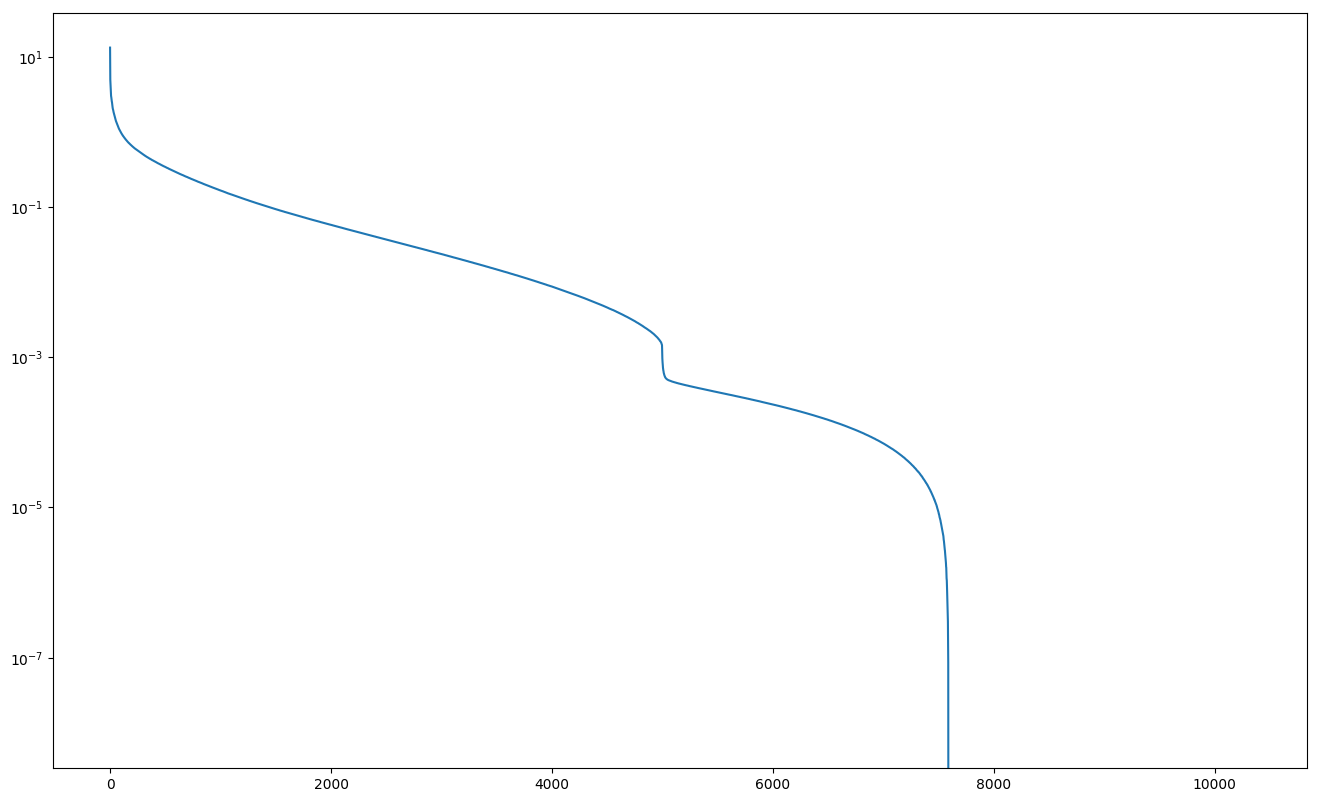

In [79]:
plt.plot(lamb)
plt.yscale("log")

In [83]:
cutoff_mode = 4000
filtered_lamb = np.copy(lamb)
filtered_B_inv, filtered_lamb, P = get_filtered_B_inv_lambda_and_P(
    filtered_lamb, cutoff_mode, P)

filtered_gamma = np.dot(filtered_B_inv, tiny_A)

In [85]:
filtered_gamma

array([ 1.44175108,  4.06574525, -2.13315186, ..., -1.68745657,
        1.63009815, -3.73252787])

In [67]:
n_ = "tiny_list_phi_pairwise_contact_multiLetter_well4.5_6.5_5.0_10phi_density_mediated_contact_multiLetter_well6.5_9.5_5.0_10_2.6_7.0phi_burial_multiLetter_well4.0_gamma"

loaded_gamma  = np.loadtxt(pre + "gammas/" + n_)


In [69]:
gamma

array([-4865.34292738,   645.34698215,  -395.00300896, ...,
        3570.68405269,   908.02470773, -1562.03103954])

In [70]:
loaded_gamma

array([-2.21172497e+09, -1.61475776e+09,  1.07436481e+10, ...,
       -1.87896822e+10, -4.27710740e+10, -5.14471321e+10])

In [68]:
gamma - loaded_gamma

array([ 2.21172011e+09,  1.61475840e+09, -1.07436484e+10, ...,
        1.87896858e+10,  4.27710749e+10,  5.14471305e+10])

In [61]:
np.sum(abs((sub_half_B_1 + sub_half_B_2)/5 - half_B))

207.80719200000743

In [62]:
207.80719200000743/10320/10320

1.9511972687940124e-06

In [60]:
half_B.shape

(10320, 10320)

# matached

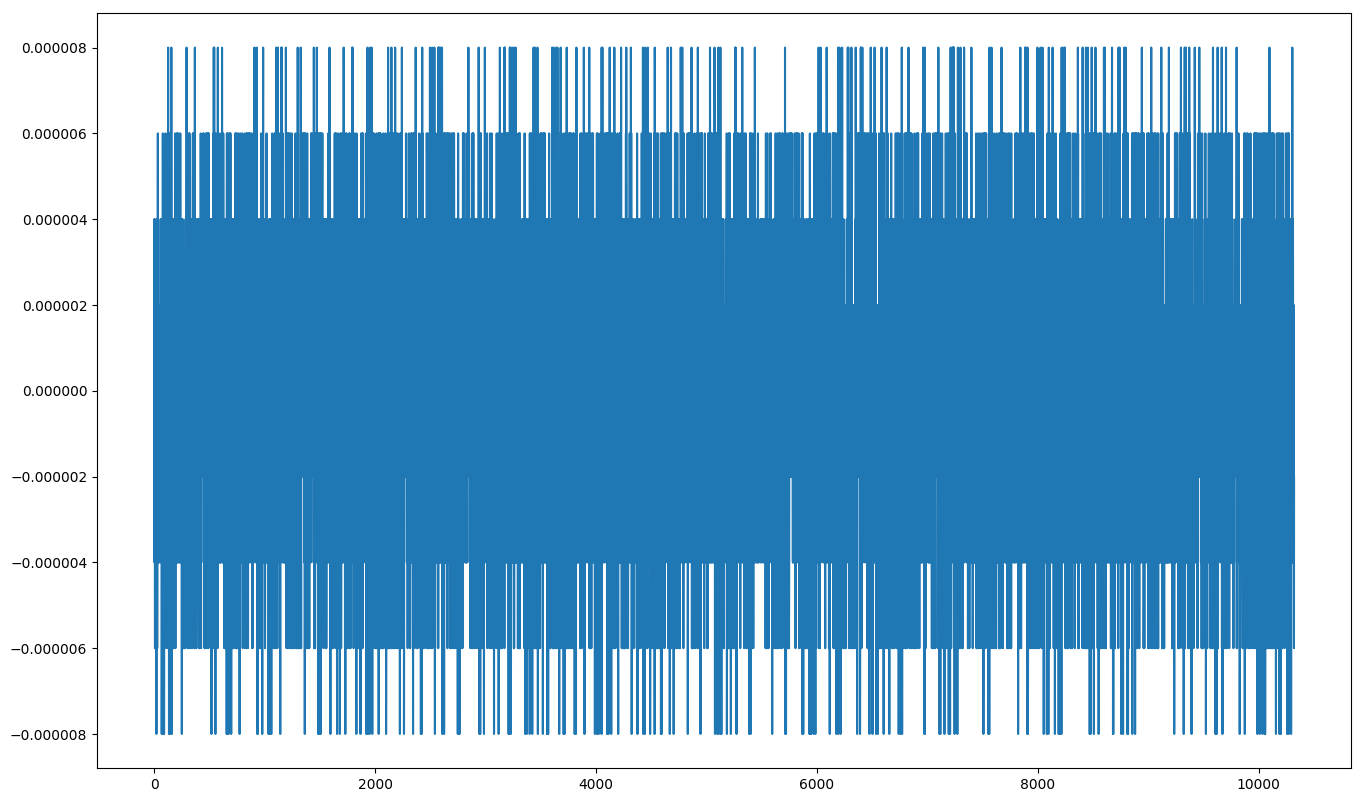

In [52]:
plt.plot(tiny_A-sub_A)

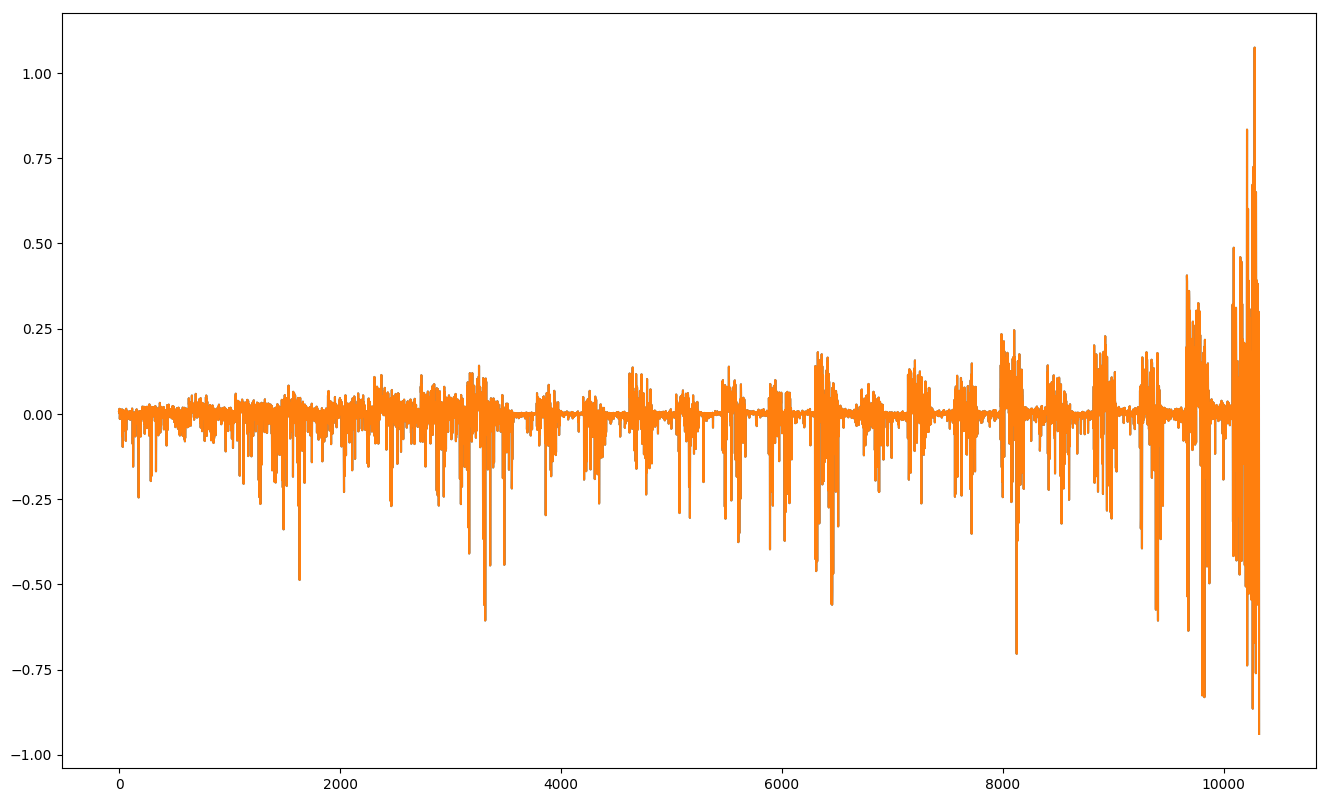

In [53]:
plt.plot(tiny_A)
plt.plot(sub_A)